In [5]:
# importing the required libraries
import pandas as pd
import re
import nltk
import numpy as np
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm
from scipy.special import softmax
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
import langid
from nltk import FreqDist
import random
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import pickle

In [6]:
# Loading  the Excel file
df = pd.read_excel('HumbersideFire.xlsx')

In [7]:
excel_data = pd.read_excel('HumbersideFire%20lang%3Aen%20-is%3Aretweet.xlsx', sheet_name=None)
df2 = excel_data['Contributors']

### Data Exploration

In [8]:
df

User          Username            UTC Date  \
0             Community Safety           @HP_CSU 2023-11-08 22:16:00   
1         JCPinHumber/NthYorks      @JCPinHumber 2023-11-08 14:01:00   
2             Community Safety           @HP_CSU 2023-11-08 13:35:18   
3     Humberside Fire & Rescue   @HumbersideFire 2023-11-08 12:23:49   
4             Kristian Gilmore  @GilmoreKri51696 2023-11-07 23:01:06   
...                        ...               ...                 ...   
5522  Humberside Fire & Rescue   @HumbersideFire 2019-11-10 03:11:20   
5523             Lesley Tidder      @lallytidder 2019-11-09 21:46:38   
5524        Chris Blacksell DL    @ExChiefChrisB 2019-11-09 08:59:37   
5525      UK USA FIRE & POLICE   @FIREUKANDWORLD 2019-11-09 08:48:44   
5526        Chris Blacksell DL    @ExChiefChrisB 2019-11-09 06:27:01   

                                                  Tweet  Binders  \
0     Really informative talk from an Ex Member HM F...      NaN   
1     Procurement Assistant @HumbersideFire in Hull\...      NaN   
2     Better Together Event hosted by @Humberbeat co...      NaN   
3     Last night you might have seen one of our Rook...      NaN   
4     @HallMohame77536 @Sinan05073661 @elquimeras @R...      NaN   
...                                                 ...      ...   
5522  Control - HFRS deploying two High Volume Pumps...      NaN   
5523  @HumbersideFire I work at a homeless hostel, r...      NaN   
5524  I’ll be on @RadioHumberside talking about the ...      NaN   
5525  1 confirmed #fatality so far from #England #fl...      NaN   
5526  Another night @HumbersideFire saving lives . I...      NaN   

                                              Permalink  Retweets  \
0     https://www.twitter.com/user/status/1722377457...         0   
1     https://www.twitter.com/user/status/1722252885...         0   
2     https://www.twitter.com/user/status/1722246417...         2   
3     https://www.twitter.com/user/status/1722228429...         2   
4     https://www.twitter.com/user/status/1722026420...         0   
...                                                 ...       ...   
5522  https://www.twitter.com/user/status/1193365494...         8   
5523  https://www.twitter.com/user/status/1193283781...         0   
5524  https://www.twitter.com/user/status/1193090757...         6   
5525  https://www.twitter.com/user/status/1193088017...         0   
5526  https://www.twitter.com/user/status/1193052354...        10   

      Likes count  Impressions  Quotes  Replies  Bookmarks  Tweet value  
0               6          185       0        0          0         5.27  
1               1           58       0        0          0        24.41  
2              14          440       0        0          0         5.27  
3               9         1420       0        1          0        90.93  
4               0            8       0        0          0         0.00  
...           ...          ...     ...      ...        ...          ...  
5522           60            0       2        0          0        90.93  
5523            2            0       0        0          0         0.02  
5524           38            0       0        2          0        18.08  
5525            0            0       0        0          0         0.10  
5526           88            0       1        2          0        18.08  

[5527 rows x 13 columns]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5527 entries, 0 to 5526
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   User         5527 non-null   object        
 1   Username     5527 non-null   object        
 2   UTC Date     5527 non-null   datetime64[ns]
 3   Tweet        5527 non-null   object        
 4   Binders      0 non-null      float64       
 5   Permalink    5527 non-null   object        
 6   Retweets     5527 non-null   int64         
 7   Likes count  5527 non-null   int64         
 8   Impressions  5527 non-null   int64         
 9   Quotes       5527 non-null   int64         
 10  Replies      5527 non-null   int64         
 11  Bookmarks    5527 non-null   int64         
 12  Tweet value  5527 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(6), object(4)
memory usage: 561.5+ KB


In [10]:
print("Dimensions of the dataset:", df.shape)

Dimensions of the dataset: (5527, 13)


In [11]:
df.describe()

UTC Date  Binders     Retweets  Likes count  \
count                           5527      0.0  5527.000000  5527.000000   
mean   2021-12-29 06:25:59.622941952      NaN     2.356251    12.320427   
min              2019-11-09 06:27:01      NaN     0.000000     0.000000   
25%              2020-11-28 03:15:49      NaN     0.000000     1.000000   
50%              2022-03-10 17:56:58      NaN     1.000000     5.000000   
75%       2022-12-11 16:02:36.500000      NaN     3.000000    14.000000   
max              2023-11-08 22:16:00      NaN   199.000000   469.000000   
std                              NaN      NaN     5.257219    23.465978   

        Impressions       Quotes      Replies    Bookmarks  Tweet value  
count   5527.000000  5527.000000  5527.000000  5527.000000  5527.000000  
mean     268.345214     0.285688     0.618600     0.014474    31.532732  
min        0.000000     0.000000     0.000000     0.000000     0.000000  
25%        0.000000     0.000000     0.000000     0.000000     1.070000  
50%        0.000000     0.000000     0.000000     0.000000     5.270000  
75%        0.000000     0.000000     1.000000     0.000000    75.780000  
max    17200.000000    22.000000    93.000000     2.000000  1550.450000  
std      960.493508     0.864917     2.099067     0.123908    57.284382

In [12]:
df2

User                                     Username  \
0            @dkcblain                                   Dave Blain   
1     @katehil18441245                                  kate hilton   
2          @mick_grant  Ashbyman #VoteLabour#Keep Safe#Join A Union   
3       @Andrew69Hagan                                  Biggestspud   
4        @VickiHowells                                Vicki Howells   
...                ...                                          ...   
1440   @elephantinclus     Elephant in The Room Disability Services   
1441   @Paul_F_McCourt                                 Paul McCourt   
1442        @Beth_Hanc                                         Beth   
1443  @shipsinthesky63                        SHIPS in the SKY🚢Hull   
1444       @mrslee1970                                  Melanie Lee   

                       Location  Total tweets  Retweets  Images  Links  Chats  \
0                           NaN             1         0       0      0      0   
1     Saxby All Saints, England             1         0       1      1      0   
2                         Ashby             2         0       0      0      1   
3           North West, England             1         0       0      0      1   
4                           NaN             1         0       0      0      1   
...                         ...           ...       ...     ...    ...    ...   
1440             United Kingdom             1         0       0      0      1   
1441                 Humberside            39         0      23     46     10   
1442   Yorkshire and The Humber            22         0      13     20      3   
1443                    HU1 3LY             1         0       0      1      0   
1444              Hull, England             3         0       1      2      1   

      Text tweets  Impressions  Quotes  Replies  Bookmarks  Tweet value  \
0               1            0       0        0          0          NaN   
1               0            0       0        0          0          NaN   
2               1            0       0        0          0          NaN   
3               0          108       0        0          0          NaN   
4               0            0       0        0          0          NaN   
...           ...          ...     ...      ...        ...          ...   
1440            0            0       0        0          0          NaN   
1441            2           96      11       24          1          NaN   
1442            0        18194       5        6          1          NaN   
1443            0            0       0        0          0          NaN   
1444            1            0       1        3          0          NaN   

      Followers  Following                                                Bio  \
0           550        686  Independent Safeguarding Consultant. DHR and S...   
1            50        169                                                NaN   
2           174        271  North Lincs Labour Councillor For Ashby. All v...   
3            66        406  A bit of this and a bit of that in the wonderf...   
4            69        340                                                NaN   
...         ...        ...                                                ...   
1440       1585       3658  Inclusion and Access Consultancy. \n\n#Consult...   
1441        612        630  Husband & dedicated HiFi anorak, Dad to 3 amaz...   
1442        151        221  Brough | Work at Humberside Fire | Bodybuildin...   
1443       2667       3520  @BlanchePictures arts project about the Hull #...   
1444        528       1249  Married to @pdlee celebrated the old Silver An...   

      User value  Tweets value  
0           1.54          1.54  
1           0.16          0.21  
2           0.52          0.62  
3           0.20          0.04  
4           0.21          0.04  
...          ...           ...  
1440        3.59          0.72  
1441        1.75         67.04  
1442        0.46     

In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1445 entries, 0 to 1444
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   User          1445 non-null   object 
 1   Username      1445 non-null   object 
 2   Location      1088 non-null   object 
 3   Total tweets  1445 non-null   int64  
 4   Retweets      1445 non-null   int64  
 5   Images        1445 non-null   int64  
 6   Links         1445 non-null   int64  
 7   Chats         1445 non-null   int64  
 8   Text tweets   1445 non-null   int64  
 9   Impressions   1445 non-null   int64  
 10  Quotes        1445 non-null   int64  
 11  Replies       1445 non-null   int64  
 12  Bookmarks     1445 non-null   int64  
 13  Tweet value   0 non-null      float64
 14  Followers     1445 non-null   int64  
 15  Following     1445 non-null   int64  
 16  Bio           1248 non-null   object 
 17  User value    1445 non-null   float64
 18  Tweets value  1445 non-null 

In [14]:
df2.describe()

Total tweets  Retweets       Images        Links        Chats  \
count   1445.000000    1445.0  1445.000000  1445.000000  1445.000000   
mean       3.824913       0.0     1.904498     4.149481     0.924567   
std       40.426952       0.0    31.346345    59.454641     4.991182   
min        1.000000       0.0     0.000000     0.000000     0.000000   
25%        1.000000       0.0     0.000000     0.000000     0.000000   
50%        1.000000       0.0     0.000000     1.000000     0.000000   
75%        2.000000       0.0     1.000000     2.000000     1.000000   
max     1416.000000       0.0  1159.000000  2200.000000   153.000000   

       Text tweets    Impressions       Quotes     Replies    Bookmarks  \
count  1445.000000    1445.000000  1445.000000  1445.00000  1445.000000   
mean      0.387543    1026.397232     1.092734     2.36609     0.055363   
std       2.795299   20854.307395    20.832028    35.39654     0.846850   
min       0.000000       0.000000     0.000000     0.00000     0.000000   
25%       0.000000       0.000000     0.000000     0.00000     0.000000   
50%       0.000000       0.000000     0.000000     0.00000     0.000000   
75%       0.000000      53.000000     0.000000     1.00000     0.000000   
max      90.000000  782431.000000   767.000000  1128.00000    30.000000   

       Tweet value      Followers     Following   User value   Tweets value  
count          0.0    1445.000000   1445.000000  1445.000000    1445.000000  
mean           NaN    4066.674048   1065.236678     9.487474     120.609972  
std            NaN   26794.235137   1963.441541    53.750411    3137.915419  
min            NaN       0.000000      1.000000     0.000000       0.000000  
25%            NaN     155.000000    194.000000     0.460000       0.260000  
50%            NaN     633.000000    532.000000     1.730000       1.490000  
75%            NaN    1739.000000   1210.000000     4.650000       6.650000  
max            NaN  683508.000000  41823.000000  1409.500000  118752.950000

In [15]:
unique_locations = df2['Location'].unique()
print("Unique Locations:")
print(unique_locations)


Unique Locations:
[nan 'Saxby All Saints, England' 'Ashby' 'North West, England'
 '53.22739  -4.129263000000037' 'Somerset. Recommends' 'California, USA'
 'Hull, England' 'Scunthorpe (Crosby)' 'Hull' 'Nottingham, England'
 'England, United Kingdom' 'East Riding of Yorkshire '
 'Yorkshire and The Humber' 'North Yorkshire' 'Market Weighton'
 'Grimsby, England' 'Hessle, England' 'Immingham, UK' 'York, UK'
 'Yorkshire and The Humber, Engl' 'Yorkshire' 'Beverley, England'
 'Hessle, East Riding Yorkshire' 'Hull, UK' 'East Yorkshire'
 '53 cliff closes rd,Scunthorpe' 'Scunthorpe, England' 'Penketh, England'
 'Frodsham, England' 'Burton Constable, Hull, England' 'Yorkshire, UK'
 'United Kingdom' 'South Oxfordshire' 'Sheffield, England' 'Earth'
 '7 Lakes Country Park, Crowle, ' 'Kingston Upon Hull ' 'London, England'
 'Moreton-in-Marsh, Cotswolds.' 'Southeast Tennessee, USA'
 'Grimsby, Scunthorpe, Goole' 'Group Manager Dave Gilbert' 'Beverley'
 'University of Hull' 'Grimsby' 'York, England' 'Kil

C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


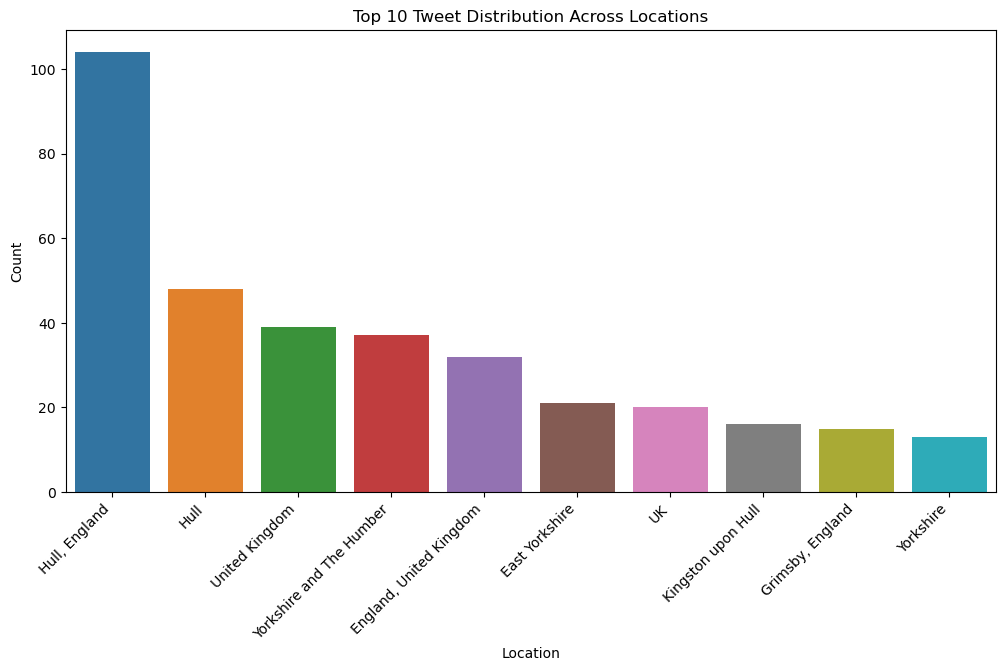

In [16]:
top_locations_limit = 10  

top_locations = df2['Location'].value_counts().index[:top_locations_limit]

df_top_locations = df2[df2['Location'].isin(top_locations)]

plt.figure(figsize=(12, 6))
sns.countplot(x='Location', data=df_top_locations, order=top_locations)
plt.title(f'Top {top_locations_limit} Tweet Distribution Across Locations')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


In [17]:
# Statistics for Retweets, Likes count, Replies
df['Retweets'] = df['Retweets'].astype(int)
df['Likes count'] = df['Likes count'].astype(int)
df['Replies'] = df['Replies'].astype(int)

# User engagement metrics
total_retweets = df['Retweets'].sum()
total_likes = df['Likes count'].sum()
total_replies = df['Replies'].sum()

average_retweets = df['Retweets'].mean()
average_likes = df['Likes count'].mean()
average_replies = df['Replies'].mean()


print(f"Total Retweets: {total_retweets}")
print(f"Total Likes: {total_likes}")
print(f"Total Replies: {total_replies}")
print(f"Average Retweets per Tweet: {average_retweets:.2f}")
print(f"Average Likes per Tweet: {average_likes:.2f}")
print(f"Average Replies per Tweet: {average_replies:.2f}")


Total Retweets: 13023
Total Likes: 68095
Total Replies: 3419
Average Retweets per Tweet: 2.36
Average Likes per Tweet: 12.32
Average Replies per Tweet: 0.62


In [18]:
# Identifying influential users based on retweets, likes, and replies
influential_users_retweets = df.groupby('Username')['Retweets'].sum().sort_values(ascending=False).head(10)
influential_users_likes = df.groupby('Username')['Likes count'].sum().sort_values(ascending=False).head(10)
influential_users_replies = df.groupby('Username')['Replies'].sum().sort_values(ascending=False).head(10)

C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


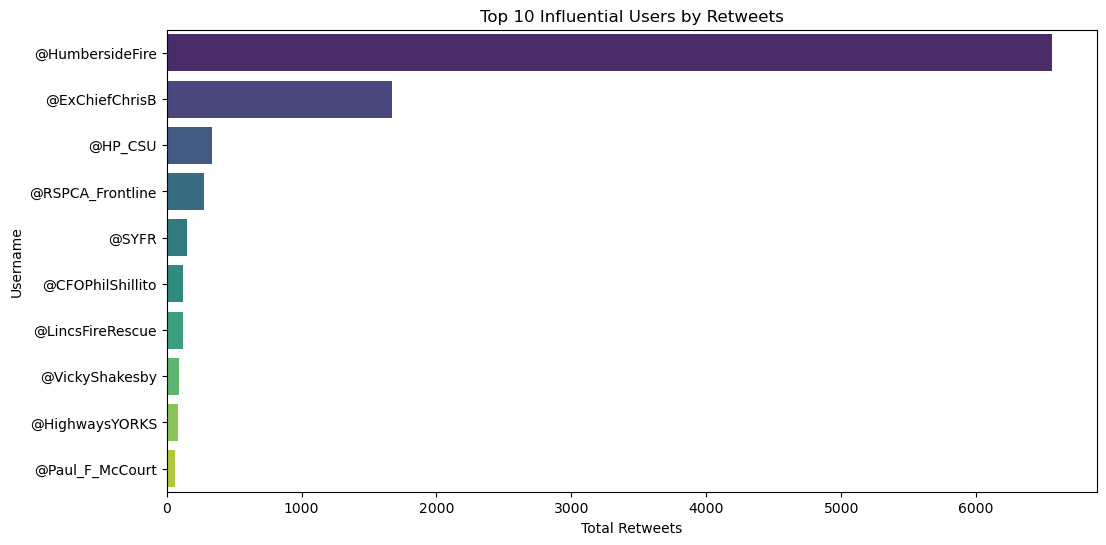

<Figure size 640x480 with 0 Axes>

In [19]:

# Visualizing influential users based on retweets
plt.figure(figsize=(12, 6))
sns.barplot(x=influential_users_retweets.values, y=influential_users_retweets.index, palette='viridis')
plt.title('Top 10 Influential Users by Retweets')
plt.xlabel('Total Retweets')
plt.ylabel('Username')
plt.show()
plt.savefig('Top 10 Influential Users by Retweets.png')

C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


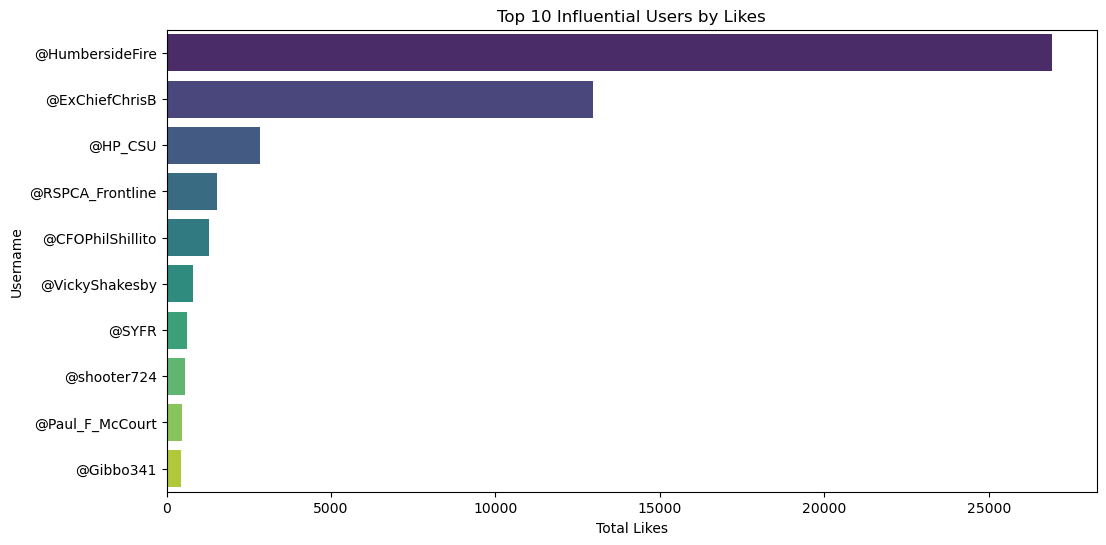

<Figure size 640x480 with 0 Axes>

In [20]:

# Visualizing influential users based on likes
plt.figure(figsize=(12, 6))
sns.barplot(x=influential_users_likes.values, y=influential_users_likes.index, palette='viridis')
plt.title('Top 10 Influential Users by Likes')
plt.xlabel('Total Likes')
plt.ylabel('Username')
plt.show()
plt.savefig('Top 10 Influential Users by Likes.png')

C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


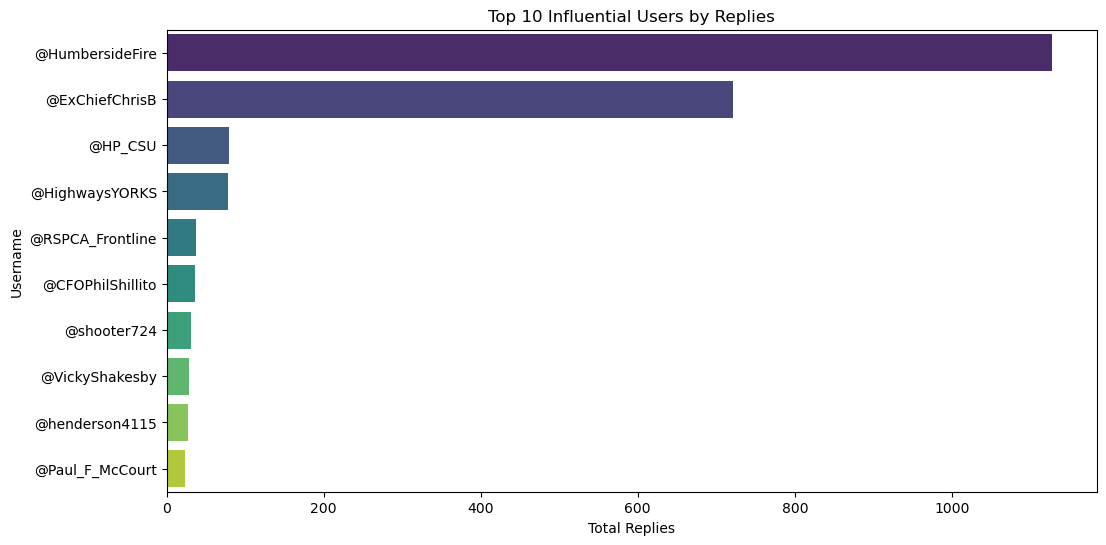

<Figure size 640x480 with 0 Axes>

In [21]:
# Visualizing influential users based on replies
plt.figure(figsize=(12, 6))
sns.barplot(x=influential_users_replies.values, y=influential_users_replies.index, palette='viridis')
plt.title('Top 10 Influential Users by Replies')
plt.xlabel('Total Replies')
plt.ylabel('Username')
plt.show()
plt.savefig('Top 10 Influential Users by Replies.png')

In [22]:
df['User'].value_counts()

User
Humberside Fire & Rescue        1416
Chris Blacksell DL               516
Community Safety                 266
Phil Shillito                     88
National Highways: Yorkshire      67
                                ... 
SW                                 1
Deborah Shep                       1
Humber Roads Police                1
FCN NORTH                          1
Lesley Tidder                      1
Name: count, Length: 1435, dtype: int64

In [23]:
df['User'].nunique()

1435

In [24]:
# Extracting the top 10 most retweeted tweets
top_10_retweeted = df.nlargest(30, 'Retweets')

pd.set_option('display.max_colwidth', None)  
print("Top 30 Most Retweeted Tweets:")
print(top_10_retweeted[['User', 'Retweets', 'Tweet']])


Top 30 Most Retweeted Tweets:
                          User  Retweets  \
4915  Humberside Fire & Rescue       199   
3123  Humberside Fire & Rescue       108   
5479  Humberside Fire & Rescue        92   
2231        Chris Blacksell DL        62   
4919  Humberside Fire & Rescue        52   
5487  Humberside Fire & Rescue        44   
5240  Humberside Fire & Rescue        39   
3073  Humberside Fire & Rescue        38   
4724  Humberside Fire & Rescue        38   
4743  Humberside Fire & Rescue        37   
5521        Chris Blacksell DL        37   
3097  Humberside Fire & Rescue        36   
4475  Humberside Fire & Rescue        36   
4833  Humberside Fire & Rescue        36   
1209        Chris Blacksell DL        35   
2951  Humberside Fire & Rescue        35   
3845           RSPCA Frontline        35   
4439      South Yorkshire Fire        35   
3337        Chris Blacksell DL        33   
5140  Humberside Fire & Rescue        33   
2813        Chris Blacksell DL        31   
30

In [25]:
pd.reset_option('display.max_colwidth')  

In [26]:
df['UTC Date'].value_counts()

UTC Date
2023-10-01 16:13:32    2
2022-10-14 17:51:37    2
2023-09-04 14:35:56    2
2023-10-16 14:59:02    2
2023-05-04 12:26:33    2
                      ..
2022-10-12 21:59:12    1
2022-10-12 23:19:32    1
2022-10-13 05:33:44    1
2022-10-13 05:46:55    1
2019-11-09 06:27:01    1
Name: count, Length: 5506, dtype: int64

C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


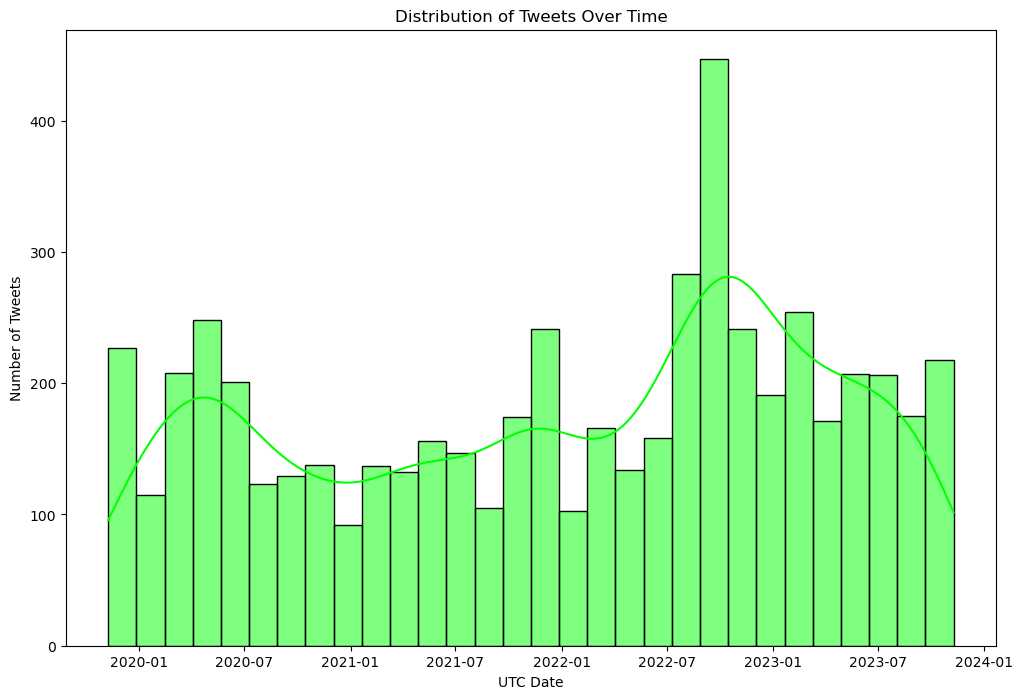

<Figure size 640x480 with 0 Axes>

In [27]:
# Exploring the distribution of tweets over time 
df['UTC Date'] = pd.to_datetime(df['UTC Date'])

plt.figure(figsize=(12, 8))
sns.histplot(df['UTC Date'], bins=30, kde=True, color='lime')
plt.title('Distribution of Tweets Over Time')
plt.xlabel('UTC Date')
plt.ylabel('Number of Tweets')
plt.show()
plt.savefig('Distibution of tweets over time.png')

C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


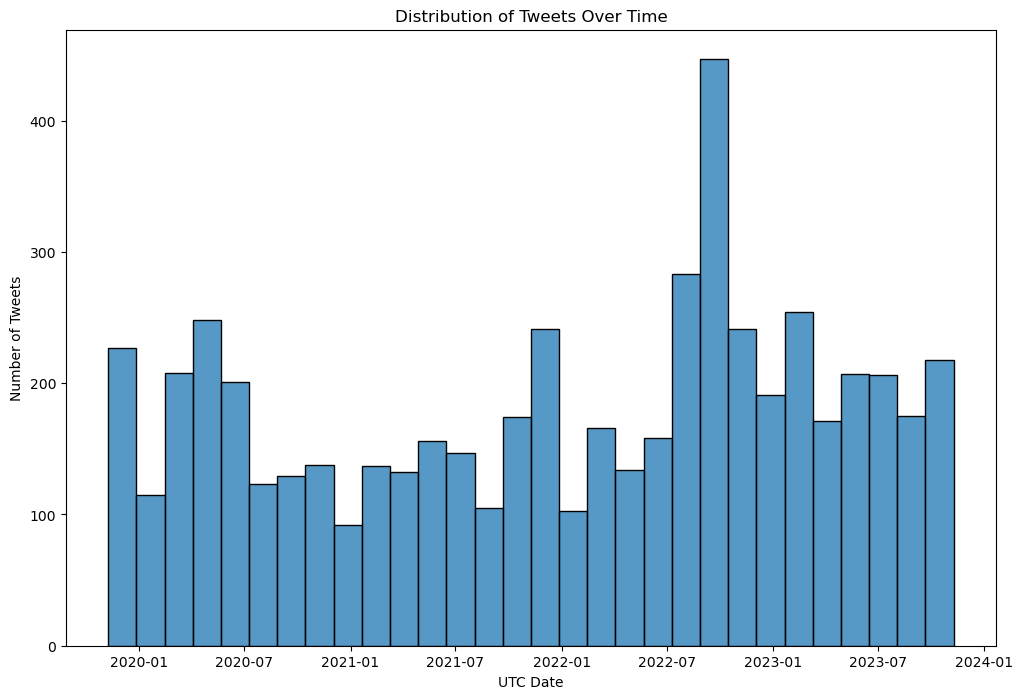

In [28]:
# Exploring the distribution of tweets over time 
df['UTC Date'] = pd.to_datetime(df['UTC Date'])

plt.figure(figsize=(12, 8))
sns.histplot(df['UTC Date'], bins=30, kde=False)
plt.title('Distribution of Tweets Over Time')
plt.xlabel('UTC Date')
plt.ylabel('Number of Tweets')
plt.show()

In [29]:
df['Tweet'] = df['Tweet'].astype(str)  

# Function to extract hashtags and mentions
def extract_hashtags_mentions(text):
    hashtags = re.findall(r'#\w+', text)
    mentions = re.findall(r'@\w+', text)
    return hashtags, mentions

# Applying the function to each tweet
df['Hashtags'], df['Mentions'] = zip(*df['Tweet'].apply(extract_hashtags_mentions))

# Flatten the list of hashtags and mentions for analysis
all_hashtags = [tag.lower() for sublist in df['Hashtags'] for tag in sublist]
all_mentions = [mention.lower() for sublist in df['Mentions'] for mention in sublist]


C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


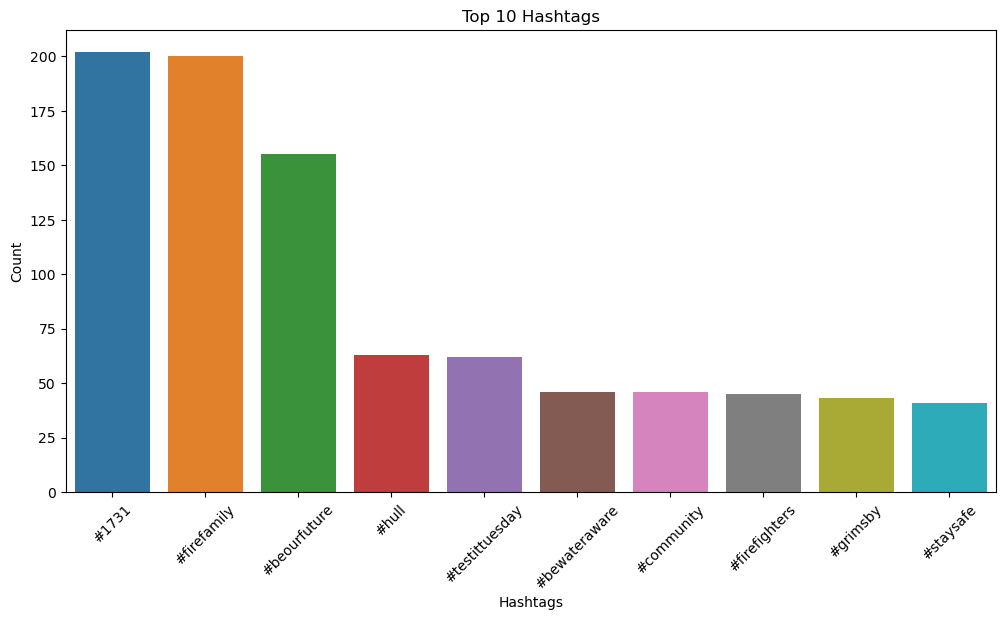

In [30]:
# Visualizng the frequency of hashtags
plt.figure(figsize=(12, 6))
sns.countplot(x=all_hashtags, order=pd.Series(all_hashtags).value_counts().index[:10])
plt.title('Top 10 Hashtags')
plt.xlabel('Hashtags')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


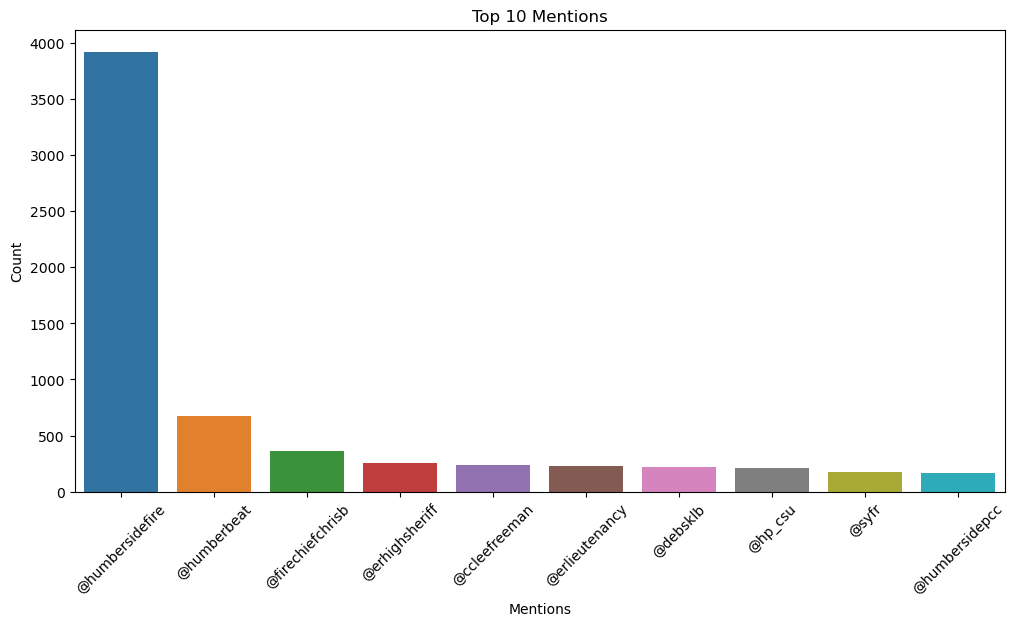

In [31]:
# Visualizing the frequency of mentions
plt.figure(figsize=(12, 6))
sns.countplot(x=all_mentions, order=pd.Series(all_mentions).value_counts().index[:10])
plt.title('Top 10 Mentions')
plt.xlabel('Mentions')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [32]:
# Extracting the top 10 most liked tweets
top_10_liked = df.nlargest(10, 'Likes count')

print("Top 10 Most Liked Tweets:")
print(top_10_liked[['User', 'Likes count', 'Tweet']])

Top 10 Most Liked Tweets:
                          User  Likes count  \
3076  Humberside Fire & Rescue          469   
4915  Humberside Fire & Rescue          407   
4475  Humberside Fire & Rescue          344   
1842        Chris Blacksell DL          336   
3646                Peter Levy          336   
4743  Humberside Fire & Rescue          276   
2770        Chris Blacksell DL          259   
4942  Humberside Fire & Rescue          251   
4833  Humberside Fire & Rescue          228   
3743  Humberside Fire & Rescue          223   

                                                  Tweet  
3076  Shout out to our crews and partner agencies 🤩....  
4915  You won't need to ask the audience, phone a fr...  
4475  Job done by humbersidefire yesterday rescuing ...  
1842  Can’t describe the emotions right now. Just am...  
3646  Great work by @HumbersideFire tonight. What a ...  
4743  So our crews at Hatfield Moor incident have re...  
2770  I first walked through the door of @Humbersi

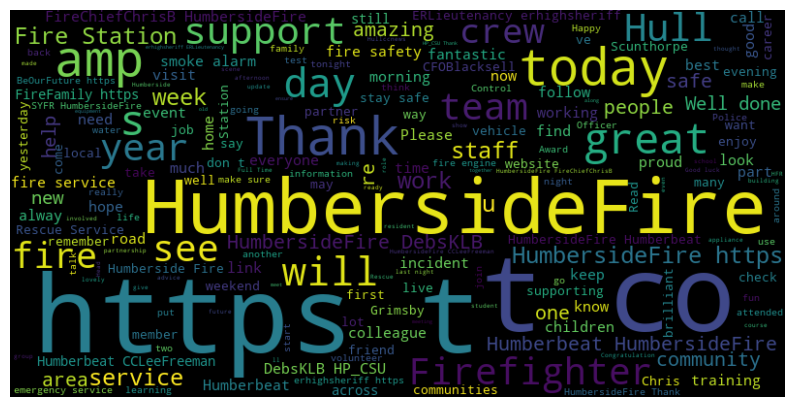

In [33]:
# Word Cloud for frequency of keywords in tweets
text = ' '.join(df['Tweet'].astype(str))
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Data Cleaning and Pre-Processing

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5527 entries, 0 to 5526
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   User         5527 non-null   object        
 1   Username     5527 non-null   object        
 2   UTC Date     5527 non-null   datetime64[ns]
 3   Tweet        5527 non-null   object        
 4   Binders      0 non-null      float64       
 5   Permalink    5527 non-null   object        
 6   Retweets     5527 non-null   int32         
 7   Likes count  5527 non-null   int32         
 8   Impressions  5527 non-null   int64         
 9   Quotes       5527 non-null   int64         
 10  Replies      5527 non-null   int32         
 11  Bookmarks    5527 non-null   int64         
 12  Tweet value  5527 non-null   float64       
 13  Hashtags     5527 non-null   object        
 14  Mentions     5527 non-null   object        
dtypes: datetime64[ns](1), float64(2), int32(3), int64(3), o

In [36]:
df = df.drop_duplicates(subset=['Tweet'])

In [37]:
# Preprocessing the tweets
def preprocess_tweet(tweet):

    # Removing the mentions
    tweet = re.sub(r'@[\w]+', '', tweet)

    # Removing hashtags
    tweet = re.sub(r'#\w+', '', tweet)
    
    # Removing URLs
    tweet = re.sub(r'https?://\S+', '', tweet)
    
    # Remove non-alphabetic characters
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)
    
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(tweet)

    stopwords = set(nltk.corpus.stopwords.words('english'))
    tokens = [token.lower() for token in tokens if token.lower() not in stopwords]

    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

df['Cleaned_Tweet'] = df['Tweet'].apply(preprocess_tweet)

C:\Users\Amro\AppData\Local\Temp\ipykernel_14300\3230490882.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cleaned_Tweet'] = df['Tweet'].apply(preprocess_tweet)


In [38]:
df['Tweet'].head()

0    Really informative talk from an Ex Member HM F...
1    Procurement Assistant @HumbersideFire in Hull\...
2    Better Together Event hosted by @Humberbeat co...
3    Last night you might have seen one of our Rook...
4    @HallMohame77536 @Sinan05073661 @elquimeras @R...
Name: Tweet, dtype: object

In [39]:
df['Cleaned_Tweet'].head()

0    really informative talk ex member hm force pro...
1                       procurement assistant hull see
2    better together event hosted community coming ...
3    last night might seen one rookie red look nort...
4                                   get launch profile
Name: Cleaned_Tweet, dtype: object

In [40]:
# Tokenizing the cleaned tweets
tokenizer = TweetTokenizer()
df['Tokens'] = df['Cleaned_Tweet'].apply(lambda tweet: tokenizer.tokenize(tweet.lower()))


C:\Users\Amro\AppData\Local\Temp\ipykernel_14300\2375083866.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tokens'] = df['Cleaned_Tweet'].apply(lambda tweet: tokenizer.tokenize(tweet.lower()))



Word Frequency Analysis:
[('fire', 1411), ('amp', 689), ('today', 664), ('service', 585), ('great', 551), ('thank', 532), ('day', 493), ('thanks', 457), ('u', 416), ('year', 415), ('well', 414), ('community', 400), ('team', 389), ('safe', 373), ('safety', 357), ('firefighter', 354), ('station', 348), ('work', 347), ('crew', 341), ('support', 335)]


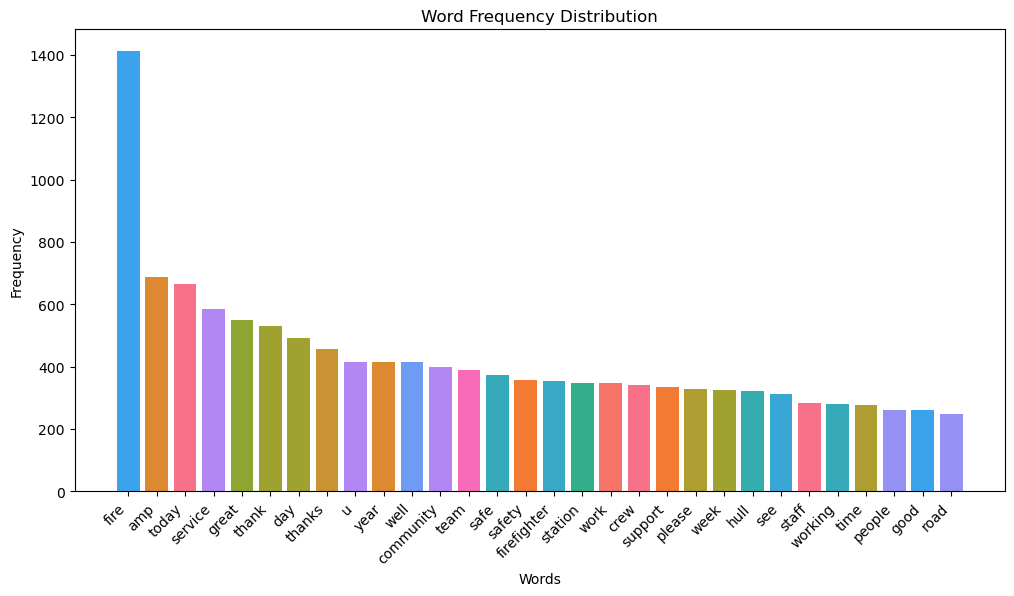

In [41]:
# Word Frequency Analysis
all_tokens = [token for tokens in df['Tokens'] for token in tokens]
freq_dist = FreqDist(all_tokens)
print("\nWord Frequency Analysis:")
print(freq_dist.most_common(20))  


plt.figure(figsize=(12, 6))
words, frequencies = zip(*freq_dist.most_common(30))
random.seed(42) 
colors = [sns.color_palette('husl', n_colors=len(words))[random.randint(0, len(words)-1)] for _ in range(len(words))]

plt.bar(words, frequencies, color=colors)
plt.title('Word Frequency Distribution')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

### Performing the Sentiment Analysis 

In [42]:
# Loading the Roberta model for sentiment analysis
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)


In [43]:
# model making predictions
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output.logits[0].detach().numpy()
    scores = softmax(scores)
    return scores

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Cleaned_Tweet'] 
        myid = i  
        roberta_result = polarity_scores_roberta(text)
        res[myid] = roberta_result.tolist()
    except RuntimeError:
        print(f'Broke for id {myid}')



100%|██████████████████████████████████████████████████████████████████████████████| 5486/5486 [04:31<00:00, 20.21it/s]


In [44]:
res

{0: [0.003928090445697308, 0.13021941483020782, 0.8658525347709656],
 1: [0.20146389305591583, 0.7299443483352661, 0.06859178096055984],
 2: [0.002524049486964941, 0.1504942774772644, 0.8469816446304321],
 3: [0.0037191251758486032, 0.7573966383934021, 0.23888424038887024],
 4: [0.09050863236188889, 0.7969785928726196, 0.11251272261142731],
 5: [0.0019166559213772416, 0.0377076230943203, 0.9603756666183472],
 6: [0.015086909756064415, 0.90799480676651, 0.07691824436187744],
 7: [0.0011569891357794404, 0.016632884740829468, 0.9822101593017578],
 8: [0.004754146561026573, 0.23990972340106964, 0.7553361654281616],
 9: [0.08277635276317596, 0.8842388987541199, 0.03298470005393028],
 10: [0.0024583975318819284, 0.03851456567645073, 0.959027111530304],
 11: [0.012419390492141247, 0.499517560005188, 0.48806312680244446],
 12: [0.0027751068118959665, 0.09521429985761642, 0.9020105600357056],
 13: [0.0034955721348524094, 0.1994759440422058, 0.7970284223556519],
 14: [0.00473057059571147, 0.0646

In [45]:
# Converting the results to a DataFrame
results_df = pd.DataFrame(res).T
results_df.columns = ['Negative', 'Neutral', 'Positive']

# Adding the sentiment scores to the existing DataFrame
df[['Negative', 'Neutral', 'Positive']] = results_df[['Negative', 'Neutral', 'Positive']]

# Mapping sentiment labels 
df['Sentiment'] = df[['Negative', 'Neutral', 'Positive']].idxmax(axis=1)
df['Sentiment'] = df['Sentiment'].map({'Negative': 'negative', 'Neutral': 'neutral', 'Positive': 'positive'})

print("Results DataFrame:")
print(df[['Cleaned_Tweet', 'Sentiment']])

Results DataFrame:
                                          Cleaned_Tweet Sentiment
0     really informative talk ex member hm force pro...  positive
1                        procurement assistant hull see   neutral
2     better together event hosted community coming ...  positive
3     last night might seen one rookie red look nort...   neutral
4                                    get launch profile   neutral
...                                                 ...       ...
5522  control hfrs deploying two high volume pump as...   neutral
5523  work homeless hostel resident heard gentleman ...  positive
5524  ill talking three significant rescue performed...   neutral
5525                       confirmed far like one going   neutral
5526  another night saving life might job stop think...  positive

[5486 rows x 2 columns]


C:\Users\Amro\AppData\Local\Temp\ipykernel_14300\1004294034.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Negative', 'Neutral', 'Positive']] = results_df[['Negative', 'Neutral', 'Positive']]
C:\Users\Amro\AppData\Local\Temp\ipykernel_14300\1004294034.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Negative', 'Neutral', 'Positive']] = results_df[['Negative', 'Neutral', 'Positive']]
C:\Users\Amro\AppData\Local\Temp\ipykernel_14300\1004294034.py:6: SettingWithCopyWarning: 
A value is trying

In [46]:
results_df

Negative   Neutral  Positive
0     0.003928  0.130219  0.865853
1     0.201464  0.729944  0.068592
2     0.002524  0.150494  0.846982
3     0.003719  0.757397  0.238884
4     0.090509  0.796979  0.112513
...        ...       ...       ...
5522  0.164026  0.800230  0.035744
5523  0.034116  0.380350  0.585534
5524  0.006148  0.636804  0.357048
5525  0.053573  0.680126  0.266302
5526  0.043647  0.433671  0.522682

[5486 rows x 3 columns]

In [47]:
df

User          Username            UTC Date  \
0             Community Safety           @HP_CSU 2023-11-08 22:16:00   
1         JCPinHumber/NthYorks      @JCPinHumber 2023-11-08 14:01:00   
2             Community Safety           @HP_CSU 2023-11-08 13:35:18   
3     Humberside Fire & Rescue   @HumbersideFire 2023-11-08 12:23:49   
4             Kristian Gilmore  @GilmoreKri51696 2023-11-07 23:01:06   
...                        ...               ...                 ...   
5522  Humberside Fire & Rescue   @HumbersideFire 2019-11-10 03:11:20   
5523             Lesley Tidder      @lallytidder 2019-11-09 21:46:38   
5524        Chris Blacksell DL    @ExChiefChrisB 2019-11-09 08:59:37   
5525      UK USA FIRE & POLICE   @FIREUKANDWORLD 2019-11-09 08:48:44   
5526        Chris Blacksell DL    @ExChiefChrisB 2019-11-09 06:27:01   

                                                  Tweet  Binders  \
0     Really informative talk from an Ex Member HM F...      NaN   
1     Procurement Assistant @HumbersideFire in Hull\...      NaN   
2     Better Together Event hosted by @Humberbeat co...      NaN   
3     Last night you might have seen one of our Rook...      NaN   
4     @HallMohame77536 @Sinan05073661 @elquimeras @R...      NaN   
...                                                 ...      ...   
5522  Control - HFRS deploying two High Volume Pumps...      NaN   
5523  @HumbersideFire I work at a homeless hostel, r...      NaN   
5524  I’ll be on @RadioHumberside talking about the ...      NaN   
5525  1 confirmed #fatality so far from #England #fl...      NaN   
5526  Another night @HumbersideFire saving lives . I...      NaN   

                                              Permalink  Retweets  \
0     https://www.twitter.com/user/status/1722377457...         0   
1     https://www.twitter.com/user/status/1722252885...         0   
2     https://www.twitter.com/user/status/1722246417...         2   
3     https://www.twitter.com/user/status/1722228429...         2   
4     https://www.twitter.com/user/status/1722026420...         0   
...                                                 ...       ...   
5522  https://www.twitter.com/user/status/1193365494...         8   
5523  https://www.twitter.com/user/status/1193283781...         0   
5524  https://www.twitter.com/user/status/1193090757...         6   
5525  https://www.twitter.com/user/status/1193088017...         0   
5526  https://www.twitter.com/user/status/1193052354...        10   

      Likes count  Impressions  Quotes  ...  Bookmarks  Tweet value  \
0               6          185       0  ...          0         5.27   
1               1           58       0  ...          0        24.41   
2              14          440       0  ...          0         5.27   
3               9         1420       0  ...          0        90.93   
4               0            8       0  ...          0         0.00   
...           ...          ...     ...  ...        ...          ...   
5522           60            0       2  ...          0        90.93   
5523            2            0       0  ...          0         0.02   
5524           38            0       0  ...          0        18.08   
5525            0            0       0  ...          0         0.10   
5526           88            0       1  ...          0        18.08   

                                               Hashtags  \
0                                     [#PCDannyFleming]   
1     [#HullJobs, #AdminJobs, #LogisticsJobs, #Emerg...   
2                                 [#PC1731DannyFleming]   
3                                        [#BeOurFuture]   
4                                                    []   
...                                                 ...   
5522                     [#onebigteam, #workingtogther]   
5523                                                 []   
5524                                                 []   
5525  [#fatality, #England, #floods, #rescues, #Hull...   
5526         

In [48]:
df.loc[10]

User                                      Humberside Fire & Rescue
Username                                           @HumbersideFire
UTC Date                                       2023-11-06 11:55:05
Tweet            We have some exciting new opportunities availa...
Binders                                                        NaN
Permalink        https://www.twitter.com/user/status/1721496422...
Retweets                                                         2
Likes count                                                      5
Impressions                                                   1308
Quotes                                                           0
Replies                                                          1
Bookmarks                                                        0
Tweet value                                                  90.93
Hashtags                               [#BeOurFuture, #FireFamily]
Mentions                                                      

### Results and Analysis

In [49]:
df['Sentiment'].value_counts()

Sentiment
positive    2884
neutral     2248
negative     354
Name: count, dtype: int64

In [50]:
df['User'].value_counts()

User
Humberside Fire & Rescue        1415
Chris Blacksell DL               516
Community Safety                 266
Phil Shillito                     88
National Highways: Yorkshire      67
                                ... 
SW                                 1
Deborah Shep                       1
Humber Roads Police                1
FCN NORTH                          1
Lesley Tidder                      1
Name: count, Length: 1434, dtype: int64

In [51]:
df[df['Sentiment']== 'neutral']

User          Username            UTC Date  \
1         JCPinHumber/NthYorks      @JCPinHumber 2023-11-08 14:01:00   
3     Humberside Fire & Rescue   @HumbersideFire 2023-11-08 12:23:49   
4             Kristian Gilmore  @GilmoreKri51696 2023-11-07 23:01:06   
6     Humberside Fire & Rescue   @HumbersideFire 2023-11-07 15:27:54   
9     Humberside Fire & Rescue   @HumbersideFire 2023-11-06 11:55:06   
...                        ...               ...                 ...   
5518  Humberside Fire & Rescue   @HumbersideFire 2019-11-10 13:40:08   
5521        Chris Blacksell DL    @ExChiefChrisB 2019-11-10 08:07:58   
5522  Humberside Fire & Rescue   @HumbersideFire 2019-11-10 03:11:20   
5524        Chris Blacksell DL    @ExChiefChrisB 2019-11-09 08:59:37   
5525      UK USA FIRE & POLICE   @FIREUKANDWORLD 2019-11-09 08:48:44   

                                                  Tweet  Binders  \
1     Procurement Assistant @HumbersideFire in Hull\...      NaN   
3     Last night you might have seen one of our Rook...      NaN   
4     @HallMohame77536 @Sinan05073661 @elquimeras @R...      NaN   
6     Tune in to BBC Look North today at 6:30pm to h...      NaN   
9     To apply now, and for more information on othe...      NaN   
...                                                 ...      ...   
5518  Remembrance ceremony at Grimsby Cenotaph atten...      NaN   
5521  ‘At the going down of the sun and in the morni...      NaN   
5522  Control - HFRS deploying two High Volume Pumps...      NaN   
5524  I’ll be on @RadioHumberside talking about the ...      NaN   
5525  1 confirmed #fatality so far from #England #fl...      NaN   

                                              Permalink  Retweets  \
1     https://www.twitter.com/user/status/1722252885...         0   
3     https://www.twitter.com/user/status/1722228429...         2   
4     https://www.twitter.com/user/status/1722026420...         0   
6     https://www.twitter.com/user/status/1721912367...         3   
9     https://www.twitter.com/user/status/1721496424...         0   
...                                                 ...       ...   
5518  https://www.twitter.com/user/status/1193523736...         3   
5521  https://www.twitter.com/user/status/1193440145...        37   
5522  https://www.twitter.com/user/status/1193365494...         8   
5524  https://www.twitter.com/user/status/1193090757...         6   
5525  https://www.twitter.com/user/status/1193088017...         0   

      Likes count  Impressions  Quotes  ...  Bookmarks  Tweet value  \
1               1           58       0  ...          0        24.41   
3               9         1420       0  ...          0        90.93   
4               0            8       0  ...          0         0.00   
6              19         2419       1  ...          0        90.93   
9               1          399       0  ...          0        15.16   
...           ...          ...     ...  ...        ...          ...   
5518           36            0       0  ...          0        90.93   
5521          206            0       3  ...          0        21.70   
5522           60            0       2  ...          0        90.93   
5524           38            0       0  ...          0        18.08   
5525            0            0       0  ...          0         0.10   

                                               Hashtags  \
1     [#HullJobs, #AdminJobs, #LogisticsJobs, #Emerg...   
3                                        [#BeOurFuture]   
4                                                    []   
6                                        [#BeOurFuture]   
9                                                    []   
...                                                 ...   
5518                                    [#LestWeForget]   
5521                [#RemembranceSunday, #LestWeForget]   
5522                     [#onebigteam, #workingtogther]   
5524                                                 []   
5525  [#fatal

In [52]:
df[df['Sentiment']== 'negative']

User          Username            UTC Date  \
28             Phillip Marshall       @PIMarshall 2023-11-02 14:48:57   
63             Community Safety           @HP_CSU 2023-10-25 16:52:51   
76             Community Safety           @HP_CSU 2023-10-23 12:50:06   
89             Community Safety           @HP_CSU 2023-10-19 11:45:10   
154                   @KateHull    @katiespitfire 2023-10-06 12:38:23   
...                         ...               ...                 ...   
5476            caroline bilton   @carolinebilton 2019-11-14 20:16:30   
5480   Humberside Fire & Rescue   @HumbersideFire 2019-11-14 17:31:16   
5482   Humberside Fire & Rescue   @HumbersideFire 2019-11-14 16:30:32   
5484            Hull Flood Risk    @Hullfloodrisk 2019-11-14 13:22:06   
5510  Miriam Heppell 💙MSc FCIPD  @miriamheppellHR 2019-11-12 10:32:27   

                                                  Tweet  Binders  \
28    @HumbersideFire No mention of headlights. Disa...      NaN   
63    It's always a privilege to be asked by a key p...      NaN   
76    With Hull City Council and partner agencies de...      NaN   
89    The CSU Manager @Humberbeat displaying the mes...      NaN   
154   Yet another historic, #grade2listed #church up...      NaN   
...                                                 ...      ...   
5476  Main slip road off A1079 into Beverley closed ...      NaN   
5480  Driving conditions worsening in some areas. Pl...      NaN   
5482  West End Road in Epworth is closed due to atte...      NaN   
5484  Hopefully today's rain will not cause us more ...      NaN   
5510  Startling statistics from Simon Gallow, Develo...      NaN   

                                              Permalink  Retweets  \
28    https://www.twitter.com/user/status/1720090625...         0   
63    https://www.twitter.com/user/status/1717222701...         2   
76    https://www.twitter.com/user/status/1716436839...         0   
89    https://www.twitter.com/user/status/1714970943...         0   
154   https://www.twitter.com/user/status/1710273295...         0   
...                                                 ...       ...   
5476  https://www.twitter.com/user/status/1195073037...         0   
5480  https://www.twitter.com/user/status/1195031458...        22   
5482  https://www.twitter.com/user/status/1195016172...        11   
5484  https://www.twitter.com/user/status/1194968753...         8   
5510  https://www.twitter.com/user/status/1194201281...         5   

      Likes count  Impressions  Quotes  ...  Bookmarks  Tweet value  \
28              0            6       0  ...          0         0.00   
63             10          407       0  ...          0         5.27   
76              8          169       0  ...          0         5.27   
89              7          196       0  ...          0         5.27   
154             0           51       0  ...          0         1.74   
...           ...          ...     ...  ...        ...          ...   
5476            1            0       1  ...          0         8.42   
5480           20            0       3  ...          0        75.78   
5482           11            0       0  ...          0        90.93   
5484           10            0       1  ...          0         3.25   
5510            6            0       0  ...          0         2.60   

                                               Hashtags  \
28                                                   []   
63                                    [#PCDannyFleming]   
76                                    [#PCDannyFleming]   
89                                [#PC1731Dannyfleming]   
154   [#grade2listed, #church, #Hull, #cleethorpes, ...   
...                                                 ...   
5476                                                 []   
5480                                                 []   
5482                                                 []   
5484                                      [#floodaware]   
55

In [53]:
df['User'].value_counts()

User
Humberside Fire & Rescue        1415
Chris Blacksell DL               516
Community Safety                 266
Phil Shillito                     88
National Highways: Yorkshire      67
                                ... 
SW                                 1
Deborah Shep                       1
Humber Roads Police                1
FCN NORTH                          1
Lesley Tidder                      1
Name: count, Length: 1434, dtype: int64

In [54]:
# List of user accounts to exclude
exclude_users = ['Humberside Fire & Rescue', 'Chris Blacksell DL','Phil Shillito', 'National Highways: Yorkshire', 'Lincolnshire Fire and Rescue']

In [55]:
# Filtering out rows with specified user accounts
filtered_df = df[~df['User'].isin(exclude_users)]

In [56]:
filtered_df

User          Username            UTC Date  \
0         Community Safety           @HP_CSU 2023-11-08 22:16:00   
1     JCPinHumber/NthYorks      @JCPinHumber 2023-11-08 14:01:00   
2         Community Safety           @HP_CSU 2023-11-08 13:35:18   
4         Kristian Gilmore  @GilmoreKri51696 2023-11-07 23:01:06   
5                     Beth        @Beth_Hanc 2023-11-07 20:18:02   
...                    ...               ...                 ...   
5517       Tony Clark QFSM  @blazerclark1237 2019-11-10 13:44:52   
5519     HFR Solutions CIC  @HFRSolutionsCIC 2019-11-10 09:45:06   
5520        Lyndsay Howden       @howden1987 2019-11-10 09:01:56   
5523         Lesley Tidder      @lallytidder 2019-11-09 21:46:38   
5525  UK USA FIRE & POLICE   @FIREUKANDWORLD 2019-11-09 08:48:44   

                                                  Tweet  Binders  \
0     Really informative talk from an Ex Member HM F...      NaN   
1     Procurement Assistant @HumbersideFire in Hull\...      NaN   
2     Better Together Event hosted by @Humberbeat co...      NaN   
4     @HallMohame77536 @Sinan05073661 @elquimeras @R...      NaN   
5     What an achievement for Our Rookie Mary, she h...      NaN   
...                                                 ...      ...   
5517  Fantastic turnout #RemembranceSunday at Howden...      NaN   
5519  On Remembrance Sunday, we are extremely proud ...      NaN   
5520  Proud to represent @HumbersideFire at the Clee...      NaN   
5523  @HumbersideFire I work at a homeless hostel, r...      NaN   
5525  1 confirmed #fatality so far from #England #fl...      NaN   

                                              Permalink  Retweets  \
0     https://www.twitter.com/user/status/1722377457...         0   
1     https://www.twitter.com/user/status/1722252885...         0   
2     https://www.twitter.com/user/status/1722246417...         2   
4     https://www.twitter.com/user/status/1722026420...         0   
5     https://www.twitter.com/user/status/1721985382...         0   
...                                                 ...       ...   
5517  https://www.twitter.com/user/status/1193524928...         2   
5519  https://www.twitter.com/user/status/1193464589...         1   
5520  https://www.twitter.com/user/status/1193453726...         3   
5523  https://www.twitter.com/user/status/1193283781...         0   
5525  https://www.twitter.com/user/status/1193088017...         0   

      Likes count  Impressions  Quotes  ...  Bookmarks  Tweet value  \
0               6          185       0  ...          0         5.27   
1               1           58       0  ...          0        24.41   
2              14          440       0  ...          0         5.27   
4               0            8       0  ...          0         0.00   
5               1          415       0  ...          0         0.51   
...           ...          ...     ...  ...        ...          ...   
5517           15            0       0  ...          0         1.85   
5519           13            0       0  ...          0         4.11   
5520           11            0       0  ...          0         0.65   
5523            2            0       0  ...          0         0.02   
5525            0            0       0  ...          0         0.10   

                                               Hashtags  \
0                                     [#PCDannyFleming]   
1     [#HullJobs, #AdminJobs, #LogisticsJobs, #Emerg...   
2                                 [#PC1731DannyFleming]   
4                                                    []   
5                                                    []   
...                                                 ...   
5517                [#RemembranceSunday, #LestWeForget]   
5519                                    [#LestWeForget]   
5520  [#RemembranceSunday, #Remembrance, #PoppyDay, ...   
5523                                                 []   
5525  [#fatality, #England, #floods, #rescues, #Hull...  

C:\Users\Amro\AppData\Local\Temp\ipykernel_14300\1599819570.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['UTC Date'] = pd.to_datetime(df['UTC Date'])
C:\Users\Amro\AppData\Local\Temp\ipykernel_14300\1599819570.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['UTC Date'].dt.year


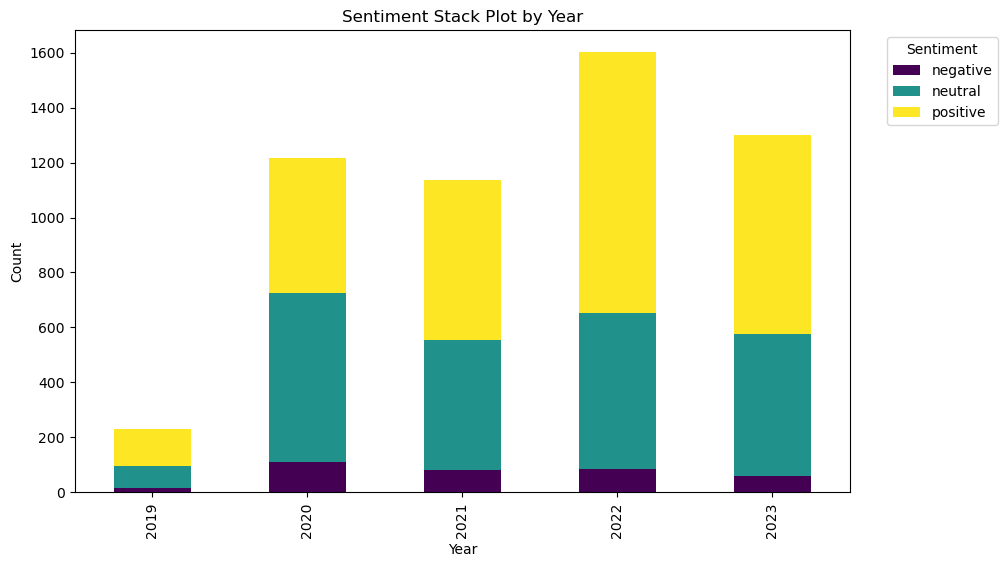

In [57]:
# Converting UTC Date to datetime format and extract year
df['UTC Date'] = pd.to_datetime(df['UTC Date'])
df['Year'] = df['UTC Date'].dt.year

# Counting sentiment occurrences for each year
sentiment_counts = df.groupby(['Year', 'Sentiment']).size().unstack(fill_value=0)

# Plotting the stack plot
sentiment_counts.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6))
plt.title('Sentiment Stack Plot by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Sentiment', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

C:\Users\Amro\AppData\Local\Temp\ipykernel_14300\1977494761.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['UTC Date'] = pd.to_datetime(filtered_df['UTC Date'])
C:\Users\Amro\AppData\Local\Temp\ipykernel_14300\1977494761.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = filtered_df['UTC Date'].dt.year
C:\Users\Amro\AppData\Local\Temp\ipykernel_14300\1977494761.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

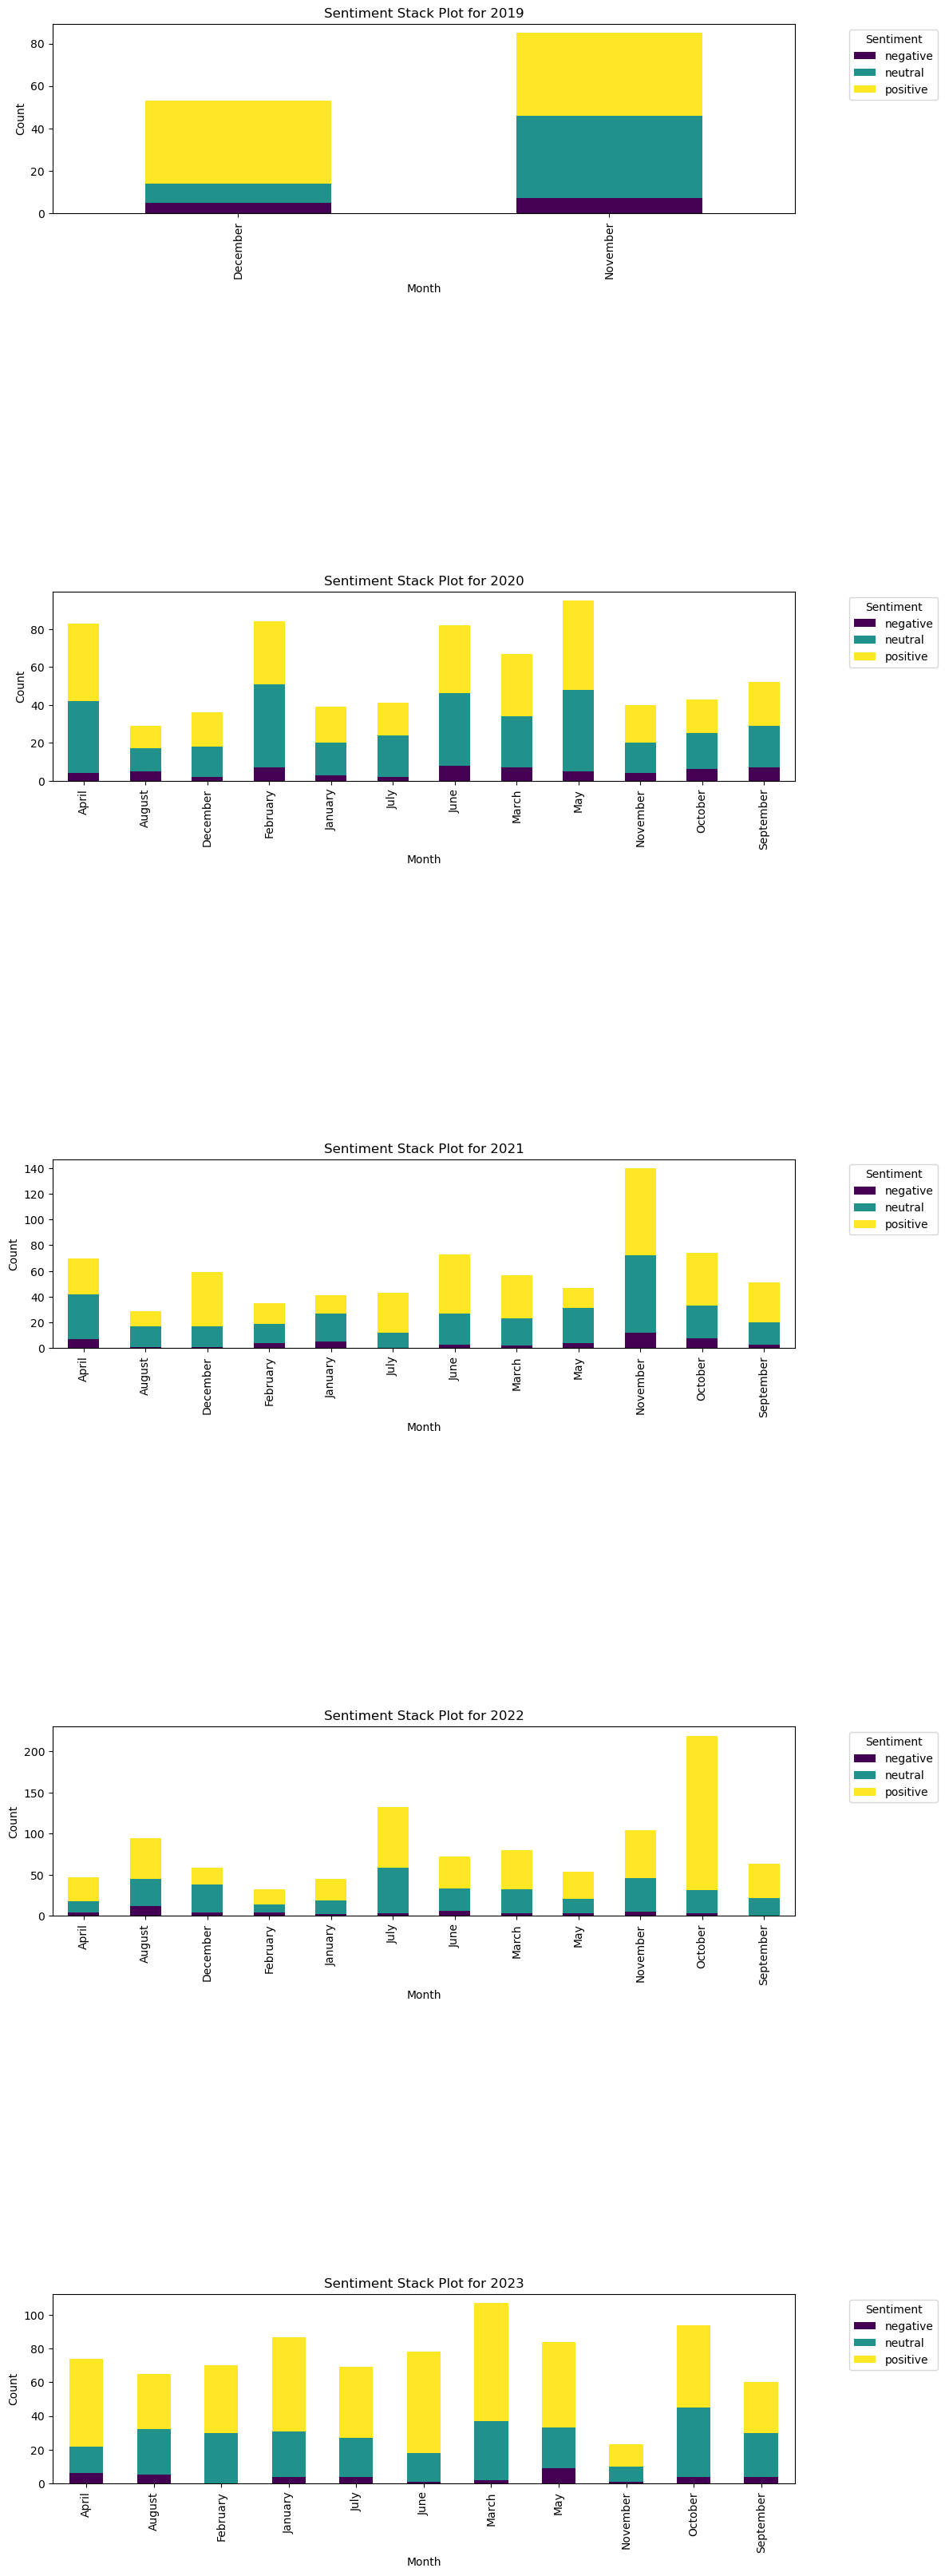

In [58]:
# Converting UTC Date to datetime format and extract year and month
filtered_df['UTC Date'] = pd.to_datetime(filtered_df['UTC Date'])
filtered_df['Year'] = filtered_df['UTC Date'].dt.year
filtered_df['Month'] = filtered_df['UTC Date'].dt.month_name()

# Counting sentiment occurrences for each year and month
sentiment_counts = filtered_df.groupby(['Year', 'Month', 'Sentiment']).size().unstack(fill_value=0).reset_index()

# Plotting the stacked plot
fig, axes = plt.subplots(nrows=len(filtered_df['Year'].unique()), ncols=1, figsize=(12, 8 * len(df['Year'].unique())))
plt.subplots_adjust(hspace=2)

for i, (year, data) in enumerate(sentiment_counts.groupby('Year')):
    ax = axes[i]
    data.drop('Year', axis=1).set_index('Month').plot(kind='bar', stacked=True, colormap='viridis', ax=ax)
    ax.set_title(f'Sentiment Stack Plot for {year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Count')
    ax.legend(title='Sentiment', loc='upper right', bbox_to_anchor=(1.2, 1))

plt.show()

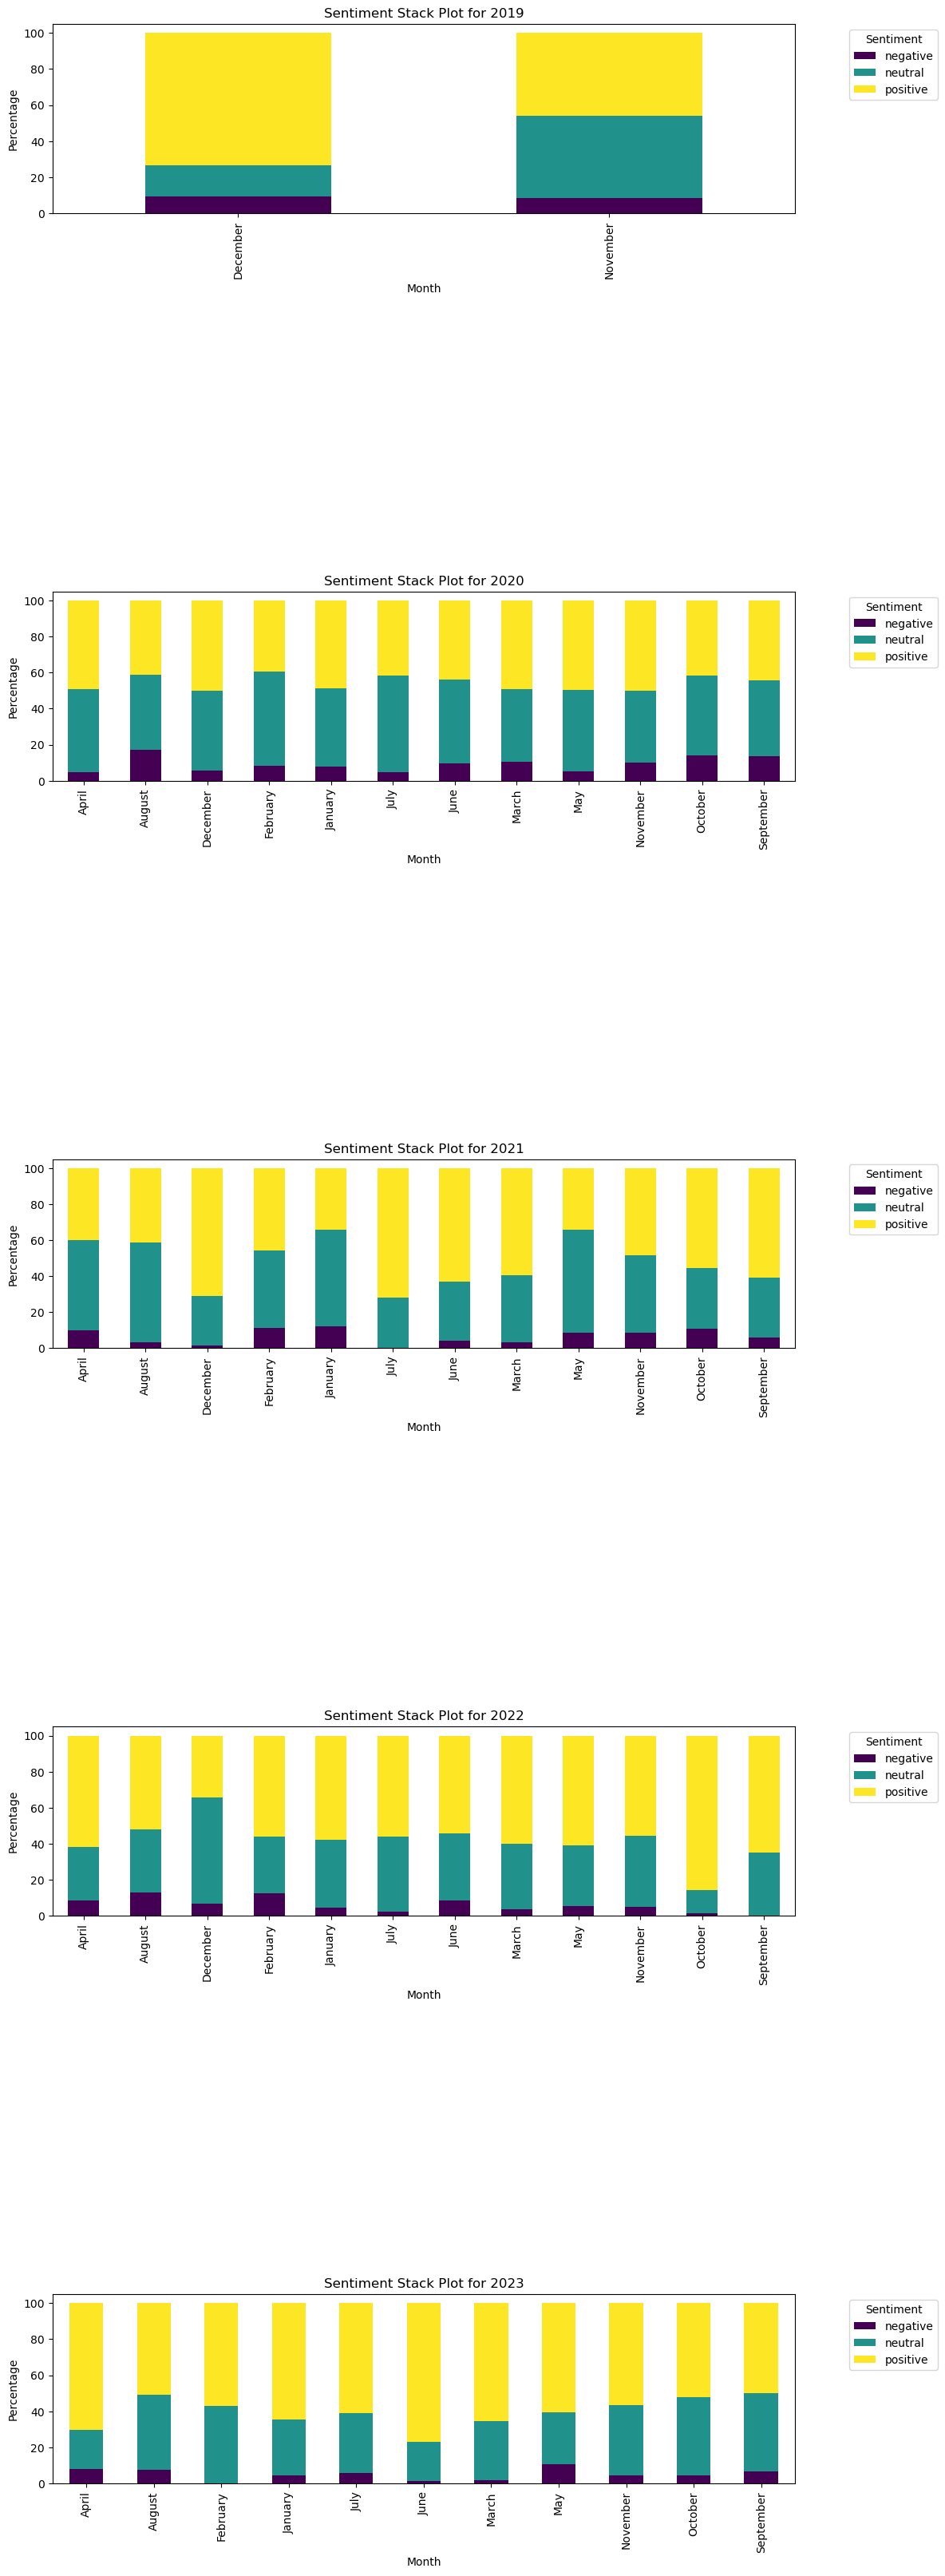

In [59]:
# Counting sentiment occurrences for each year and month
sentiment_counts = filtered_df.groupby(['Year', 'Month', 'Sentiment']).size().unstack(fill_value=0).reset_index()

# Normalizing the counts for each month to make the bars equal in length
sentiment_counts_normalized = sentiment_counts.copy()
sentiment_counts_normalized.iloc[:, 2:] = sentiment_counts_normalized.iloc[:, 2:].div(
    sentiment_counts_normalized.iloc[:, 2:].sum(axis=1), axis=0
) * 100

# Plotting stacked plot
fig, axes = plt.subplots(nrows=len(filtered_df['Year'].unique()), ncols=1, figsize=(12, 8 * len(filtered_df['Year'].unique())))
plt.subplots_adjust(hspace=2)

for i, (year, data) in enumerate(sentiment_counts_normalized.groupby('Year')):
    ax = axes[i]
    data.drop('Year', axis=1).set_index('Month').plot(kind='bar', stacked=True, colormap='viridis', ax=ax)
    ax.set_title(f'Sentiment Stack Plot for {year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Percentage')
    ax.legend(title='Sentiment', loc='upper right', bbox_to_anchor=(1.2, 1))

plt.show()

C:\Users\Amro\AppData\Local\Temp\ipykernel_14300\2133705453.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Month'] = pd.Categorical(filtered_df['Month'], categories=month_order, ordered=True)
C:\Users\Amro\AppData\Local\Temp\ipykernel_14300\2133705453.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sentiment_counts = filtered_df.groupby(['Year', 'Month', 'Sentiment']).size().unstack(fill_value=0).reset_index()


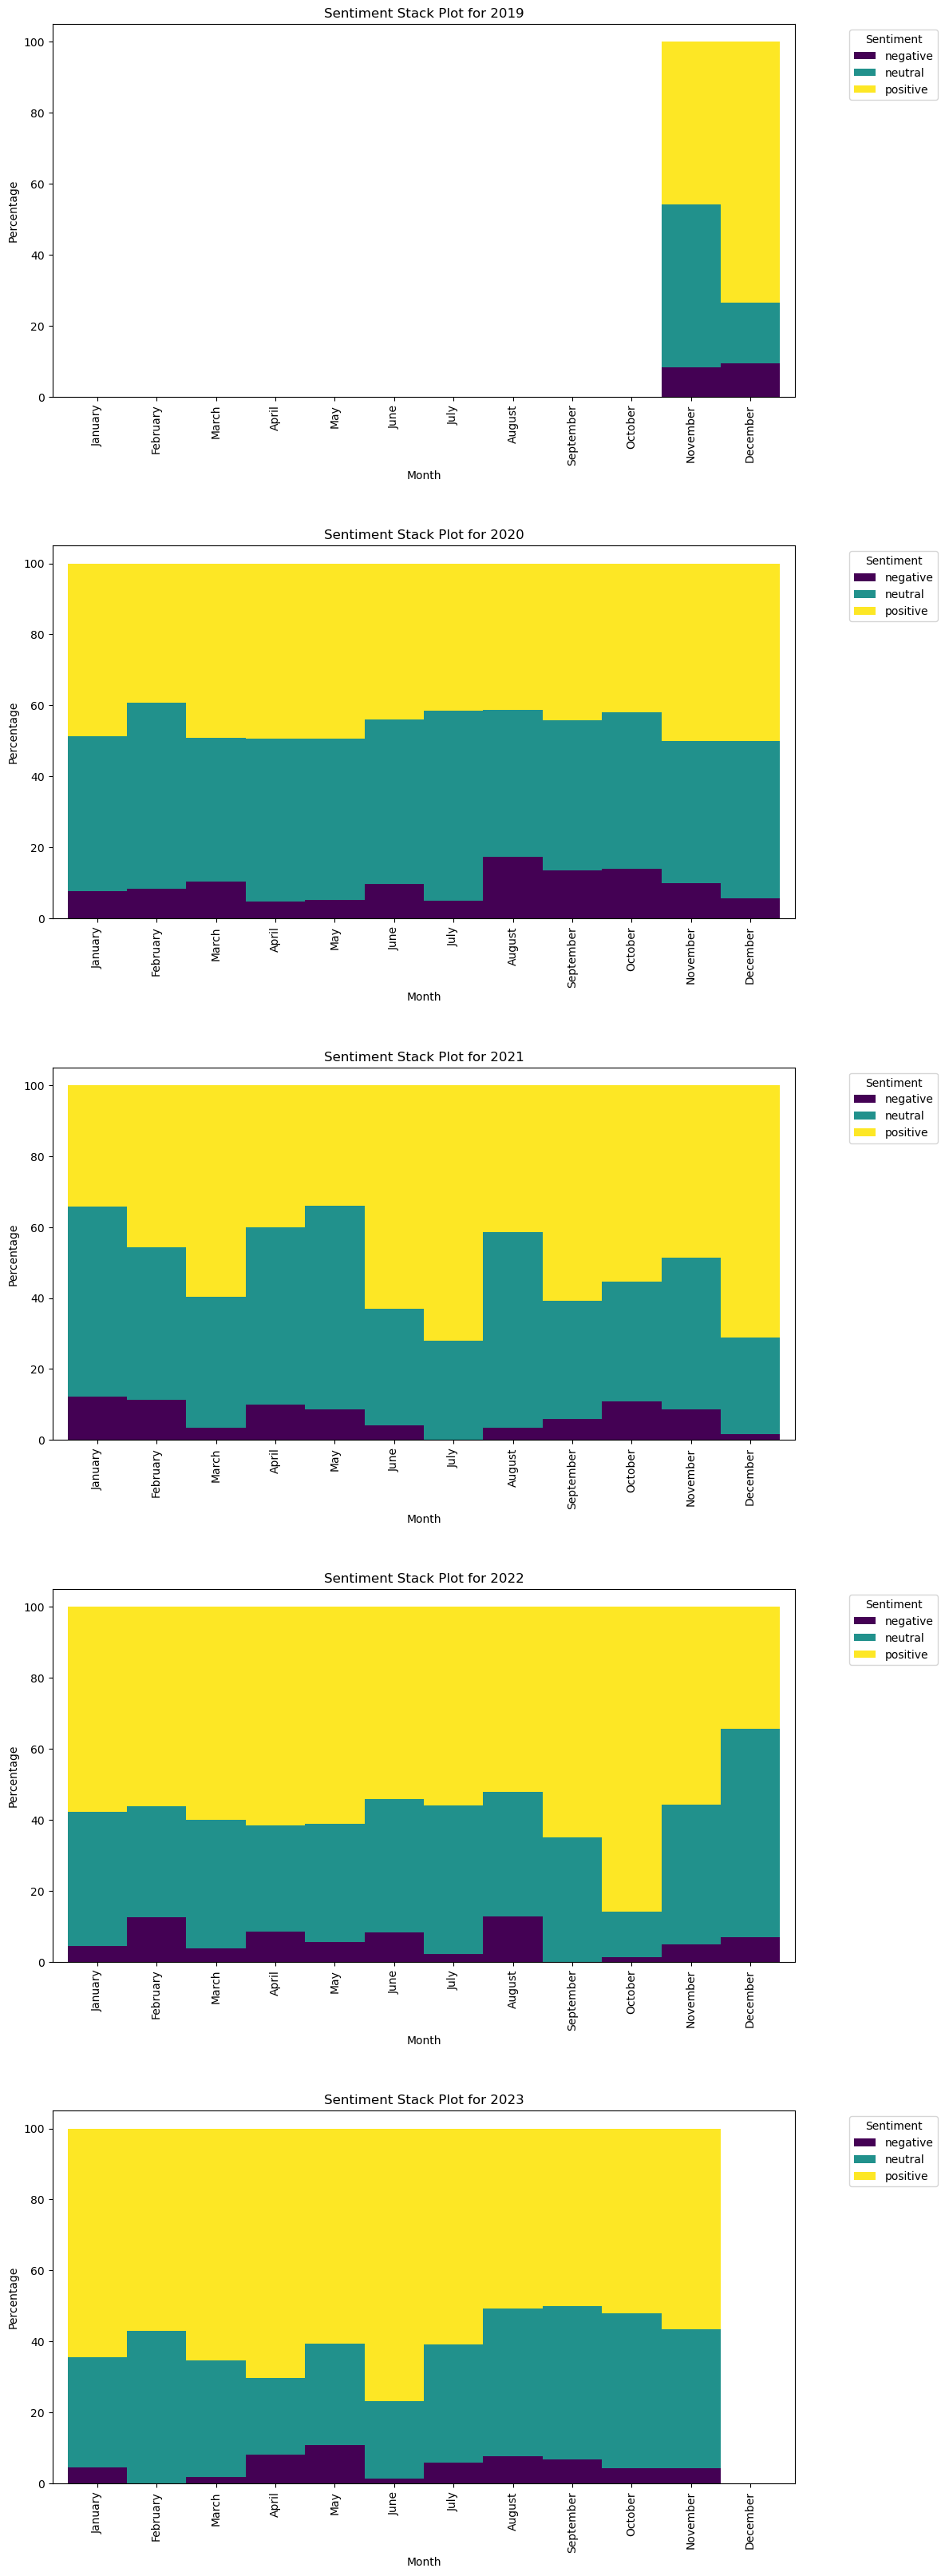

In [60]:
# Defining the order of months
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

# Converting 'Month' column to categorical with the defined order
filtered_df['Month'] = pd.Categorical(filtered_df['Month'], categories=month_order, ordered=True)

# Counting sentiment occurrences for each year and month
sentiment_counts = filtered_df.groupby(['Year', 'Month', 'Sentiment']).size().unstack(fill_value=0).reset_index()

# Normalizing the counts for each month to make the bars equal in length
sentiment_counts_normalized = sentiment_counts.copy()
sentiment_counts_normalized.iloc[:, 2:] = sentiment_counts_normalized.iloc[:, 2:].div(
    sentiment_counts_normalized.iloc[:, 2:].sum(axis=1), axis=0
) * 100

# Plotting the stacked plot
fig, axes = plt.subplots(nrows=len(filtered_df['Year'].unique()), ncols=1, figsize=(12, 8 * len(filtered_df['Year'].unique())))
plt.subplots_adjust(hspace=0.4)

for i, (year, data) in enumerate(sentiment_counts_normalized.groupby('Year')):
    ax = axes[i]
    data.drop('Year', axis=1).set_index('Month').plot(kind='bar', stacked=True, colormap='viridis', ax=ax, width=1)
    ax.set_title(f'Sentiment Stack Plot for {year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Percentage')
    ax.legend(title='Sentiment', loc='upper right', bbox_to_anchor=(1.2, 1))

plt.savefig('Stacked plot.png', bbox_inches='tight')

plt.show()

In [61]:
filtered_df

User          Username            UTC Date  \
0         Community Safety           @HP_CSU 2023-11-08 22:16:00   
1     JCPinHumber/NthYorks      @JCPinHumber 2023-11-08 14:01:00   
2         Community Safety           @HP_CSU 2023-11-08 13:35:18   
4         Kristian Gilmore  @GilmoreKri51696 2023-11-07 23:01:06   
5                     Beth        @Beth_Hanc 2023-11-07 20:18:02   
...                    ...               ...                 ...   
5517       Tony Clark QFSM  @blazerclark1237 2019-11-10 13:44:52   
5519     HFR Solutions CIC  @HFRSolutionsCIC 2019-11-10 09:45:06   
5520        Lyndsay Howden       @howden1987 2019-11-10 09:01:56   
5523         Lesley Tidder      @lallytidder 2019-11-09 21:46:38   
5525  UK USA FIRE & POLICE   @FIREUKANDWORLD 2019-11-09 08:48:44   

                                                  Tweet  Binders  \
0     Really informative talk from an Ex Member HM F...      NaN   
1     Procurement Assistant @HumbersideFire in Hull\...      NaN   
2     Better Together Event hosted by @Humberbeat co...      NaN   
4     @HallMohame77536 @Sinan05073661 @elquimeras @R...      NaN   
5     What an achievement for Our Rookie Mary, she h...      NaN   
...                                                 ...      ...   
5517  Fantastic turnout #RemembranceSunday at Howden...      NaN   
5519  On Remembrance Sunday, we are extremely proud ...      NaN   
5520  Proud to represent @HumbersideFire at the Clee...      NaN   
5523  @HumbersideFire I work at a homeless hostel, r...      NaN   
5525  1 confirmed #fatality so far from #England #fl...      NaN   

                                              Permalink  Retweets  \
0     https://www.twitter.com/user/status/1722377457...         0   
1     https://www.twitter.com/user/status/1722252885...         0   
2     https://www.twitter.com/user/status/1722246417...         2   
4     https://www.twitter.com/user/status/1722026420...         0   
5     https://www.twitter.com/user/status/1721985382...         0   
...                                                 ...       ...   
5517  https://www.twitter.com/user/status/1193524928...         2   
5519  https://www.twitter.com/user/status/1193464589...         1   
5520  https://www.twitter.com/user/status/1193453726...         3   
5523  https://www.twitter.com/user/status/1193283781...         0   
5525  https://www.twitter.com/user/status/1193088017...         0   

      Likes count  Impressions  Quotes  ...  \
0               6          185       0  ...   
1               1           58       0  ...   
2              14          440       0  ...   
4               0            8       0  ...   
5               1          415       0  ...   
...           ...          ...     ...  ...   
5517           15            0       0  ...   
5519           13            0       0  ...   
5520           11            0       0  ...   
5523            2            0       0  ...   
5525            0            0       0  ...   

                                               Hashtags  \
0                                     [#PCDannyFleming]   
1     [#HullJobs, #AdminJobs, #LogisticsJobs, #Emerg...   
2                                 [#PC1731DannyFleming]   
4                                                    []   
5                                                    []   
...                                                 ...   
5517                [#RemembranceSunday, #LestWeForget]   
5519                                    [#LestWeForget]   
5520  [#RemembranceSunday, #Remembrance, #PoppyDay, ...   
5523                                                 []   
5525  [#fatality, #England, #floods, #rescues, #Hull...   

                                               Mentions  \
0     [@Humberbeat, @NationalVPC, @ACC_TMc, @HP_Life...   
1                                     [@HumbersideFire]   
2     [@Humberbeat, @ACC_TMc, @HumbersidePCC, @Humbe...   
4     [@HallMohame77536, @Sinan05073661, @elquime

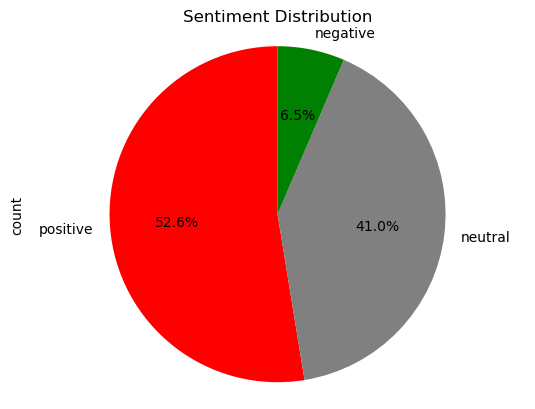

In [62]:
sentiment_counts = df['Sentiment'].value_counts()
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['red', 'gray', 'green'])
plt.title('Sentiment Distribution')
plt.axis('equal')  

plt.savefig('Sentiment Distribution.png')
plt.show()

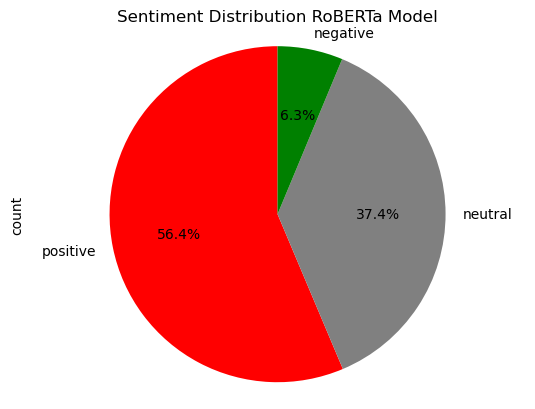

In [63]:
sentiment_counts = filtered_df['Sentiment'].value_counts()
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['red', 'gray', 'green'])
plt.title('Sentiment Distribution RoBERTa Model')
plt.axis('equal')  

plt.savefig('Sentiment Distribution RoBERTa Model.png')
plt.show()


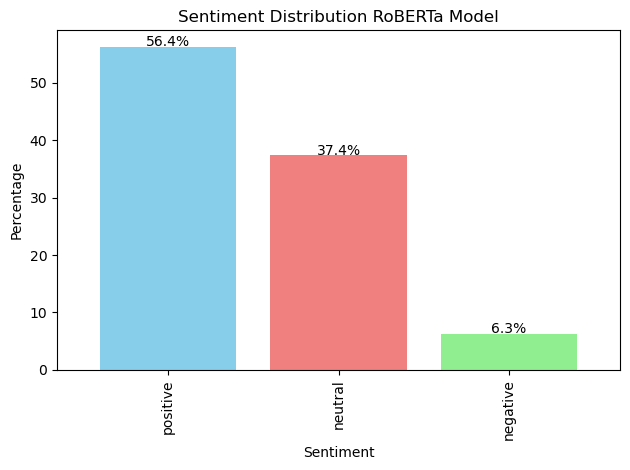

In [109]:
sentiment_counts = filtered_df['Sentiment'].value_counts()

# Calculating percentages
total_samples = len(filtered_df)
sentiment_percentages = (sentiment_counts / total_samples) * 100

sentiment_percentages.plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen'], width=0.8)

# Adding labels and title
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.title('Sentiment Distribution RoBERTa Model')


for i, percentage in enumerate(sentiment_percentages):
    plt.text(i, percentage + 0.1, f'{percentage:.1f}%', ha='center')

plt.tight_layout()

plt.savefig('Sentiment Distribution RoBERTa Model.png')
plt.show()

C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


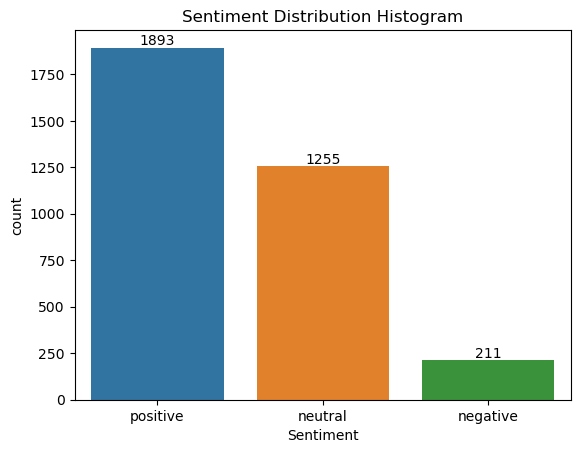

In [64]:
sentiment_counts = filtered_df['Sentiment'].value_counts()

order = sentiment_counts.index
sns.countplot(data=filtered_df, x='Sentiment', order=order)


for index, value in enumerate(sentiment_counts):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom')

plt.title('Sentiment Distribution Histogram')
plt.savefig('Sentiment Distribution Histogram.png')
plt.show()

In [65]:
filtered_df['Retweets'] = filtered_df['Retweets'].astype(int)
filtered_df['Likes count'] = filtered_df['Likes count'].astype(int)
filtered_df['Replies'] = filtered_df['Replies'].astype(int)

# User engagement metrics
total_retweets = filtered_df['Retweets'].sum()
total_likes = filtered_df['Likes count'].sum()
total_replies = filtered_df['Replies'].sum()

average_retweets = filtered_df['Retweets'].mean()
average_likes = filtered_df['Likes count'].mean()
average_replies = filtered_df['Replies'].mean()


print(f"Total Retweets: {total_retweets}")
print(f"Total Likes: {total_likes}")
print(f"Total Replies: {total_replies}")
print(f"Average Retweets per Tweet: {average_retweets:.2f}")
print(f"Average Likes per Tweet: {average_likes:.2f}")
print(f"Average Replies per Tweet: {average_replies:.2f}")

Total Retweets: 4457
Total Likes: 26425
Total Replies: 1448
Average Retweets per Tweet: 1.33
Average Likes per Tweet: 7.87
Average Replies per Tweet: 0.43


C:\Users\Amro\AppData\Local\Temp\ipykernel_14300\2072853247.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Retweets'] = filtered_df['Retweets'].astype(int)
C:\Users\Amro\AppData\Local\Temp\ipykernel_14300\2072853247.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Likes count'] = filtered_df['Likes count'].astype(int)
C:\Users\Amro\AppData\Local\Temp\ipykernel_14300\2072853247.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [66]:
# Identifying influential users based on retweets, likes, and replies
influential_users_retweets = filtered_df.groupby('Username')['Retweets'].sum().sort_values(ascending=False).head(10)
influential_users_likes = filtered_df.groupby('Username')['Likes count'].sum().sort_values(ascending=False).head(10)
influential_users_replies = filtered_df.groupby('Username')['Replies'].sum().sort_values(ascending=False).head(10)

C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


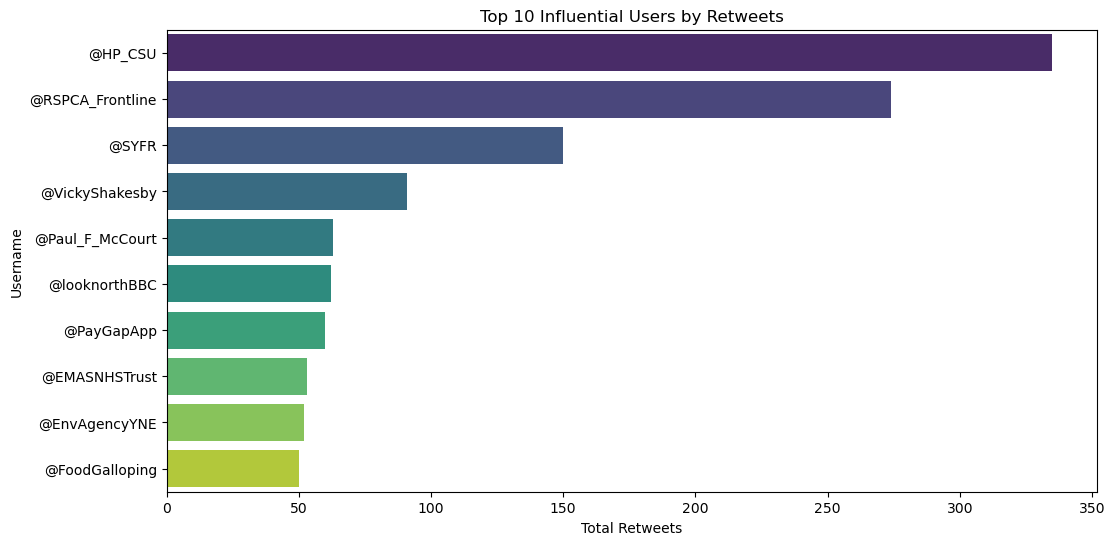

In [67]:
# Visualizing influential users based on retweets
plt.figure(figsize=(12, 6))
sns.barplot(x=influential_users_retweets.values, y=influential_users_retweets.index, palette='viridis')
plt.title('Top 10 Influential Users by Retweets')
plt.xlabel('Total Retweets')
plt.ylabel('Username')
plt.show()


C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


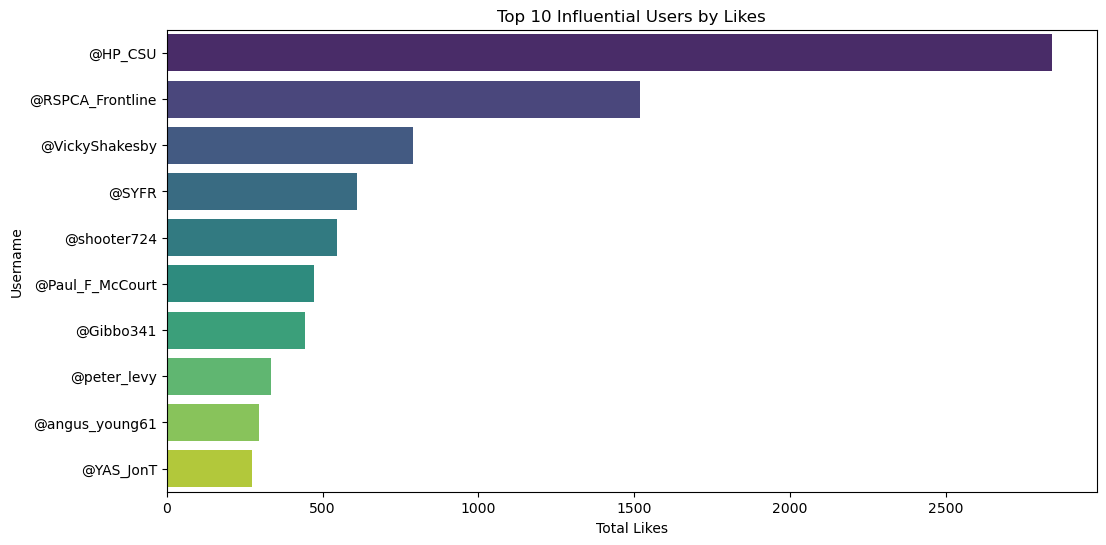

In [68]:
# Visualizing influential users based on likes
plt.figure(figsize=(12, 6))
sns.barplot(x=influential_users_likes.values, y=influential_users_likes.index, palette='viridis')
plt.title('Top 10 Influential Users by Likes')
plt.xlabel('Total Likes')
plt.ylabel('Username')
plt.show()


C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


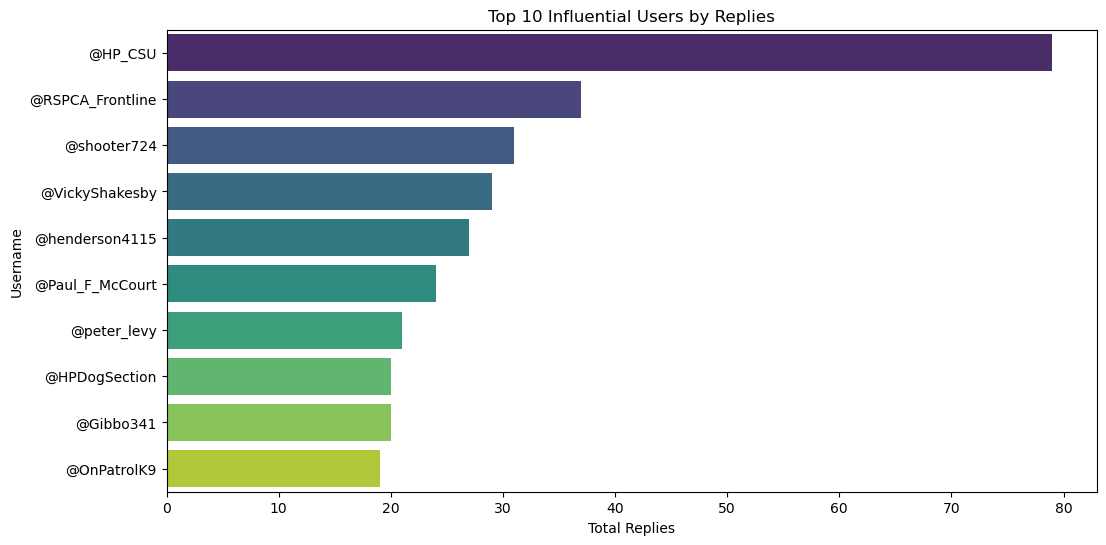

In [69]:
# Visualizing influential users based on replies
plt.figure(figsize=(12, 6))
sns.barplot(x=influential_users_replies.values, y=influential_users_replies.index, palette='viridis')
plt.title('Top 10 Influential Users by Replies')
plt.xlabel('Total Replies')
plt.ylabel('Username')
plt.show()

In [70]:
# Word Cloud for Each Sentiment
negative_tweets = filtered_df[filtered_df['Sentiment'] == 'negative']['Cleaned_Tweet'].str.cat(sep=' ')
neutral_tweets = filtered_df[filtered_df['Sentiment'] == 'neutral']['Cleaned_Tweet'].str.cat(sep=' ')
positive_tweets = filtered_df[filtered_df['Sentiment'] == 'positive']['Cleaned_Tweet'].str.cat(sep=' ')

# Generating word clouds
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_tweets)
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(neutral_tweets)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_tweets)


Text(0.5, 1.0, 'Word Cloud - Negative Sentiment ')

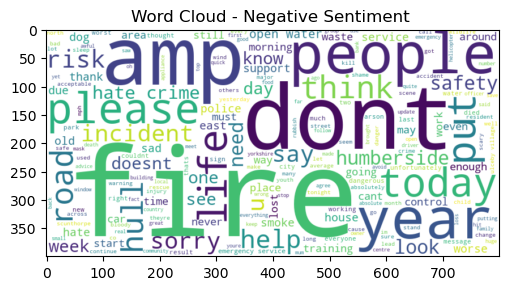

In [71]:
# Plotting word clouds
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud - Negative Sentiment ')

Text(0.5, 1.0, 'Word Cloud - Neutral Sentiment')

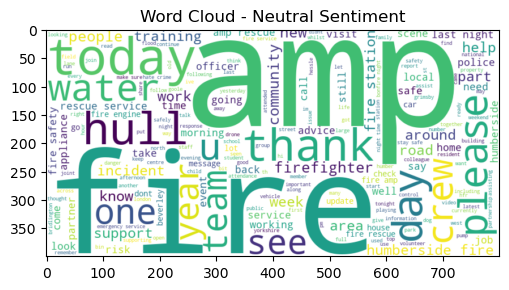

In [72]:
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 2)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Word Cloud - Neutral Sentiment')

Text(0.5, 1.0, 'Word Cloud - Positive Sentiment')

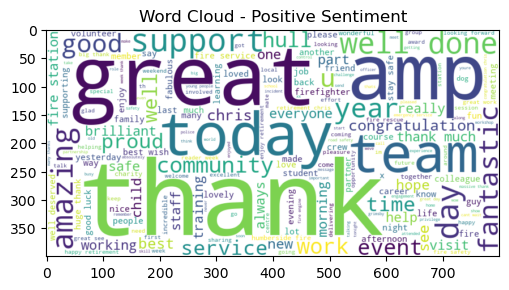

In [73]:
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 3)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud - Positive Sentiment')

In [74]:
filtered_df[filtered_df['Sentiment'] == 'negative']

User          Username            UTC Date  \
28             Phillip Marshall       @PIMarshall 2023-11-02 14:48:57   
63             Community Safety           @HP_CSU 2023-10-25 16:52:51   
76             Community Safety           @HP_CSU 2023-10-23 12:50:06   
89             Community Safety           @HP_CSU 2023-10-19 11:45:10   
154                   @KateHull    @katiespitfire 2023-10-06 12:38:23   
...                         ...               ...                 ...   
5472          Wolds View Garage       @WoldsView1 2019-11-14 21:47:20   
5473         Susan Chandler 💙🇺🇦           @SueyQP 2019-11-14 21:23:59   
5476            caroline bilton   @carolinebilton 2019-11-14 20:16:30   
5484            Hull Flood Risk    @Hullfloodrisk 2019-11-14 13:22:06   
5510  Miriam Heppell 💙MSc FCIPD  @miriamheppellHR 2019-11-12 10:32:27   

                                                  Tweet  Binders  \
28    @HumbersideFire No mention of headlights. Disa...      NaN   
63    It's always a privilege to be asked by a key p...      NaN   
76    With Hull City Council and partner agencies de...      NaN   
89    The CSU Manager @Humberbeat displaying the mes...      NaN   
154   Yet another historic, #grade2listed #church up...      NaN   
...                                                 ...      ...   
5472  @HumbersideFire North Cave beck had burst it's...      NaN   
5473  @CoultishNick @21_hardy @HumberbeatRoads @Radi...      NaN   
5476  Main slip road off A1079 into Beverley closed ...      NaN   
5484  Hopefully today's rain will not cause us more ...      NaN   
5510  Startling statistics from Simon Gallow, Develo...      NaN   

                                              Permalink  Retweets  \
28    https://www.twitter.com/user/status/1720090625...         0   
63    https://www.twitter.com/user/status/1717222701...         2   
76    https://www.twitter.com/user/status/1716436839...         0   
89    https://www.twitter.com/user/status/1714970943...         0   
154   https://www.twitter.com/user/status/1710273295...         0   
...                                                 ...       ...   
5472  https://www.twitter.com/user/status/1195095898...         0   
5473  https://www.twitter.com/user/status/1195090022...         0   
5476  https://www.twitter.com/user/status/1195073037...         0   
5484  https://www.twitter.com/user/status/1194968753...         8   
5510  https://www.twitter.com/user/status/1194201281...         5   

      Likes count  Impressions  Quotes  ...  \
28              0            6       0  ...   
63             10          407       0  ...   
76              8          169       0  ...   
89              7          196       0  ...   
154             0           51       0  ...   
...           ...          ...     ...  ...   
5472            1            0       0  ...   
5473            0            0       0  ...   
5476            1            0       1  ...   
5484           10            0       1  ...   
5510            6            0       0  ...   

                                               Hashtags  \
28                                                   []   
63                                    [#PCDannyFleming]   
76                                    [#PCDannyFleming]   
89                                [#PC1731Dannyfleming]   
154   [#grade2listed, #church, #Hull, #cleethorpes, ...   
...                                                 ...   
5472                                                 []   
5473                                                 []   
5476                                                 []   
5484                                      [#floodaware]   
5510                          [#HeForShe, #menasallies]   

                                               Mentions  \
28                                    [@HumbersideFire]   
63    [@Humberbeat, @ACC_TMc, @Hullccnews, @Humbersi...   
76    [@Humberbeat, @Hullccnews, @ACC_TMc, @Humbersi.

In [75]:
filtered_df.loc[filtered_df['Sentiment'] == 'negative', 'Cleaned_Tweet']

28                        mention headlight disappointing
63      always privilege asked key partner present hat...
76      hull city council partner agency delivering ha...
89      csu manager displaying message tackle hate wee...
154     yet another historic flame cost u heritage imp...
                              ...                        
5472    north cave beck burst bank footpath bridge pap...
5473                                        heartbreaking
5476    main slip road beverley closed due flooding ho...
5484    hopefully today rain cause u problem remember ...
5510    startling statistic simon gallow development d...
Name: Cleaned_Tweet, Length: 211, dtype: object

In [76]:
# Displaying the entire content of 'Cleaned_Tweet' for negative sentiments
negative_tweets = filtered_df.loc[filtered_df['Sentiment'] == 'negative', 'Tweet']

for tweet in negative_tweets:
    print(tweet)

@HumbersideFire No mention of headlights. Disappointing.
It's always a privilege to be asked by a key partner to present Hate Crime Training with Hull Park Rangers today... Theres No Place For Hate...
#PCDannyFleming
@Humberbeat @ACC_TMc @Hullccnews @HumbersideFire @HumbersidePCC @erhighsheriff https://t.co/qFOvfzYvdF
With Hull City Council and partner agencies delivering Hate Crime Training supporting all those effected by such crimes...
#PCDannyFleming 
@Humberbeat @Hullccnews @ACC_TMc @HumbersideFire @HumbersidePCC @erhighsheriff https://t.co/qSFYaPzxwy
The CSU Manager @Humberbeat displaying the message to "Tackle It" this Hate Week and every Week.
#PC1731Dannyfleming 
@ACC_TMc @HumbersidePCC @erhighsheriff @NationalHCAW @HumbersideFire @ERLieutenancy https://t.co/qufTc6soLW
Yet another historic, #grade2listed #church up in flames. #Hull #cleethorpes not only costs us heritage but more importantly put the lives of @HumbersideFire and their #lincolnshire colleagues at risk
@davidthom

In [77]:
df

User          Username            UTC Date  \
0             Community Safety           @HP_CSU 2023-11-08 22:16:00   
1         JCPinHumber/NthYorks      @JCPinHumber 2023-11-08 14:01:00   
2             Community Safety           @HP_CSU 2023-11-08 13:35:18   
3     Humberside Fire & Rescue   @HumbersideFire 2023-11-08 12:23:49   
4             Kristian Gilmore  @GilmoreKri51696 2023-11-07 23:01:06   
...                        ...               ...                 ...   
5522  Humberside Fire & Rescue   @HumbersideFire 2019-11-10 03:11:20   
5523             Lesley Tidder      @lallytidder 2019-11-09 21:46:38   
5524        Chris Blacksell DL    @ExChiefChrisB 2019-11-09 08:59:37   
5525      UK USA FIRE & POLICE   @FIREUKANDWORLD 2019-11-09 08:48:44   
5526        Chris Blacksell DL    @ExChiefChrisB 2019-11-09 06:27:01   

                                                  Tweet  Binders  \
0     Really informative talk from an Ex Member HM F...      NaN   
1     Procurement Assistant @HumbersideFire in Hull\...      NaN   
2     Better Together Event hosted by @Humberbeat co...      NaN   
3     Last night you might have seen one of our Rook...      NaN   
4     @HallMohame77536 @Sinan05073661 @elquimeras @R...      NaN   
...                                                 ...      ...   
5522  Control - HFRS deploying two High Volume Pumps...      NaN   
5523  @HumbersideFire I work at a homeless hostel, r...      NaN   
5524  I’ll be on @RadioHumberside talking about the ...      NaN   
5525  1 confirmed #fatality so far from #England #fl...      NaN   
5526  Another night @HumbersideFire saving lives . I...      NaN   

                                              Permalink  Retweets  \
0     https://www.twitter.com/user/status/1722377457...         0   
1     https://www.twitter.com/user/status/1722252885...         0   
2     https://www.twitter.com/user/status/1722246417...         2   
3     https://www.twitter.com/user/status/1722228429...         2   
4     https://www.twitter.com/user/status/1722026420...         0   
...                                                 ...       ...   
5522  https://www.twitter.com/user/status/1193365494...         8   
5523  https://www.twitter.com/user/status/1193283781...         0   
5524  https://www.twitter.com/user/status/1193090757...         6   
5525  https://www.twitter.com/user/status/1193088017...         0   
5526  https://www.twitter.com/user/status/1193052354...        10   

      Likes count  Impressions  Quotes  ...  Tweet value  \
0               6          185       0  ...         5.27   
1               1           58       0  ...        24.41   
2              14          440       0  ...         5.27   
3               9         1420       0  ...        90.93   
4               0            8       0  ...         0.00   
...           ...          ...     ...  ...          ...   
5522           60            0       2  ...        90.93   
5523            2            0       0  ...         0.02   
5524           38            0       0  ...        18.08   
5525            0            0       0  ...         0.10   
5526           88            0       1  ...        18.08   

                                               Hashtags  \
0                                     [#PCDannyFleming]   
1     [#HullJobs, #AdminJobs, #LogisticsJobs, #Emerg...   
2                                 [#PC1731DannyFleming]   
3                                        [#BeOurFuture]   
4                                                    []   
...                                                 ...   
5522                     [#onebigteam, #workingtogther]   
5523                                                 []   
5524                                                 []   
5525  [#fatality, #England, #floods, #rescues, #Hull...   
5526                                                 []   

                                               Mentions  \
0     [@Humberbeat, @Natio

In [78]:
num_tweets = len(filtered_df)
average_tweet_length = filtered_df['Cleaned_Tweet'].apply(lambda x: len(x.split())).mean()

# Distribution of sentiment labels
sentiment_distribution = filtered_df['Sentiment'].value_counts()


print(f"Number of Tweets: {num_tweets}")
print(f"Average Tweet Length: {average_tweet_length:.2f} words")
print("\nSentiment Distribution:")
print(sentiment_distribution)

Number of Tweets: 3359
Average Tweet Length: 11.36 words

Sentiment Distribution:
Sentiment
positive    1893
neutral     1255
negative     211
Name: count, dtype: int64


C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


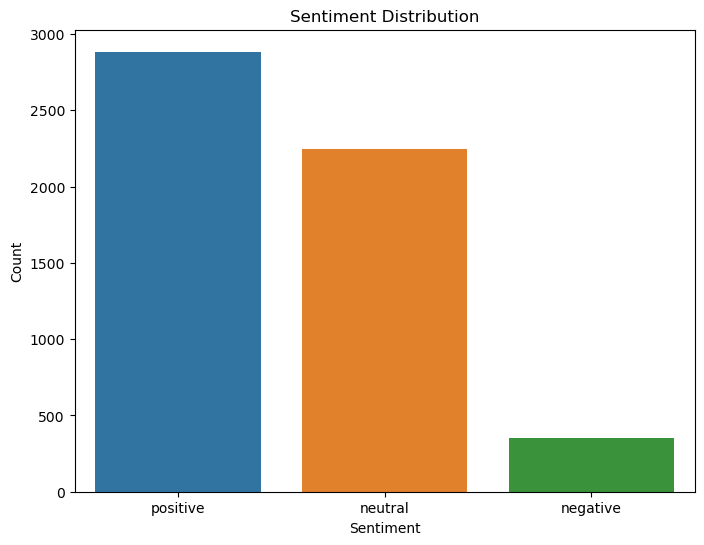

In [79]:
# Visualizating sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=df, order=df['Sentiment'].value_counts().index)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [80]:
filtered_df['Tweet'] = filtered_df['Tweet'].astype(str)  # Ensure the 'Tweet' column is treated as strings

# Functioning to extract hashtags and mentions
def extract_hashtags_mentions(text):
    hashtags = re.findall(r'#\w+', text)
    mentions = re.findall(r'@\w+', text)
    return hashtags, mentions

# Applying the function to each tweet
filtered_df['Hashtags'], filtered_df['Mentions'] = zip(*filtered_df['Tweet'].apply(extract_hashtags_mentions))

# Flatten the list of hashtags and mentions for analysis
all_hashtags = [tag.lower() for sublist in filtered_df['Hashtags'] for tag in sublist]
all_mentions = [mention.lower() for sublist in filtered_df['Mentions'] for mention in sublist]

C:\Users\Amro\AppData\Local\Temp\ipykernel_14300\3532616362.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Tweet'] = filtered_df['Tweet'].astype(str)  # Ensure the 'Tweet' column is treated as strings
C:\Users\Amro\AppData\Local\Temp\ipykernel_14300\3532616362.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Hashtags'], filtered_df['Mentions'] = zip(*filtered_df['Tweet'].apply(extract_hashtags_mentions))


In [81]:
# Setting a limit on the number of top mentions to display
top_mentions_limit = 10

C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


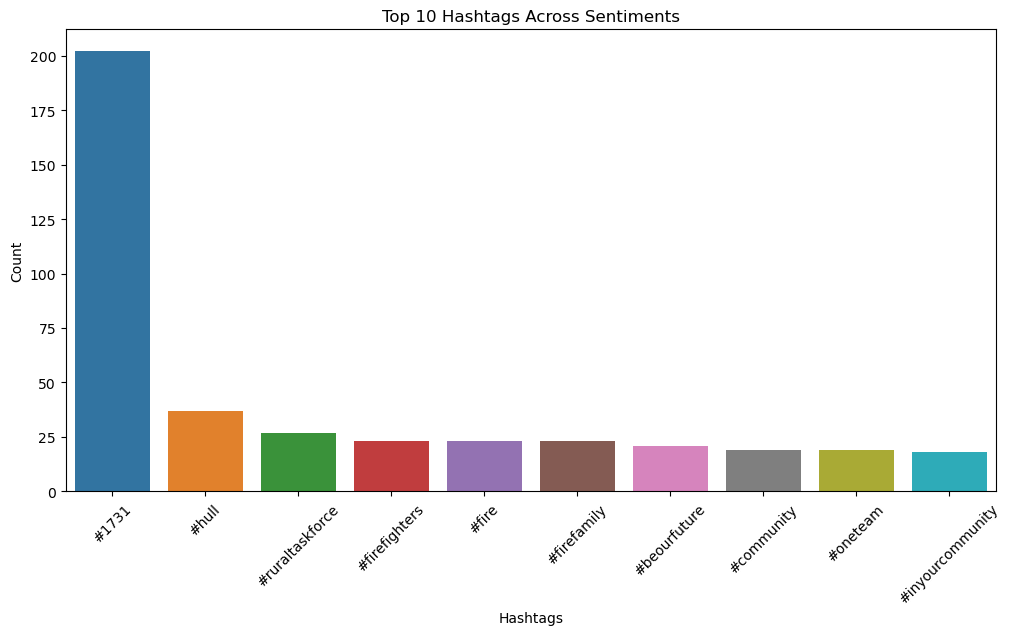

In [82]:
# Visualizing the frequency of hashtags
plt.figure(figsize=(12, 6))
sns.countplot(x=all_hashtags, order=pd.Series(all_hashtags).value_counts().index[:top_mentions_limit])
plt.title(f'Top {top_mentions_limit} Hashtags Across Sentiments')
plt.xlabel('Hashtags')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


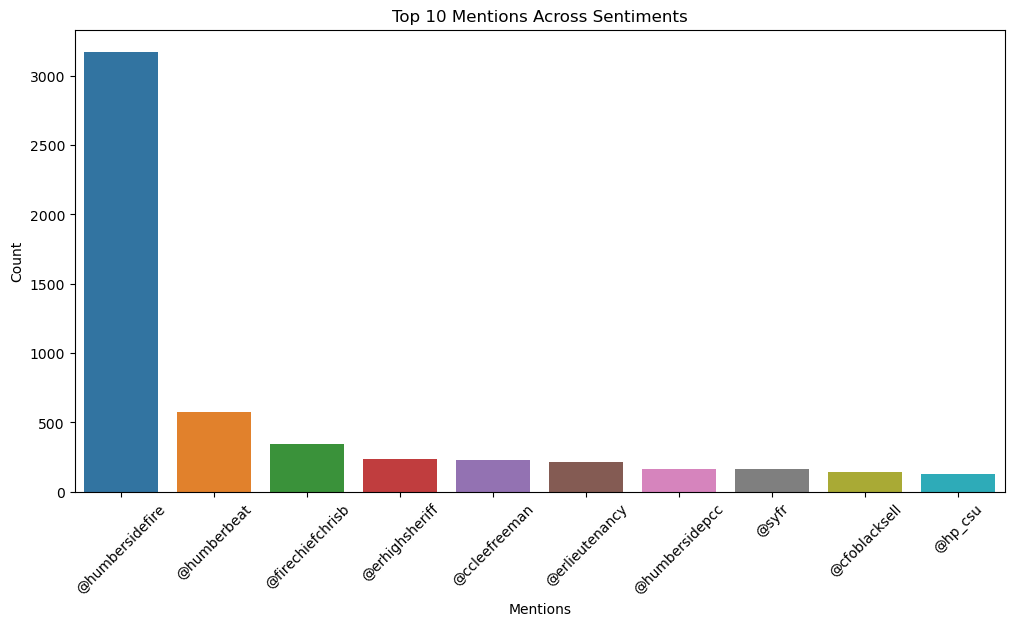

In [83]:

# Visualizing the frequency of mentions
plt.figure(figsize=(12, 6))
sns.countplot(x=all_mentions, order=pd.Series(all_mentions).value_counts().index[:top_mentions_limit])
plt.title(f'Top {top_mentions_limit} Mentions Across Sentiments')
plt.xlabel('Mentions')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Amro\anaconda3\envs\gpu2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


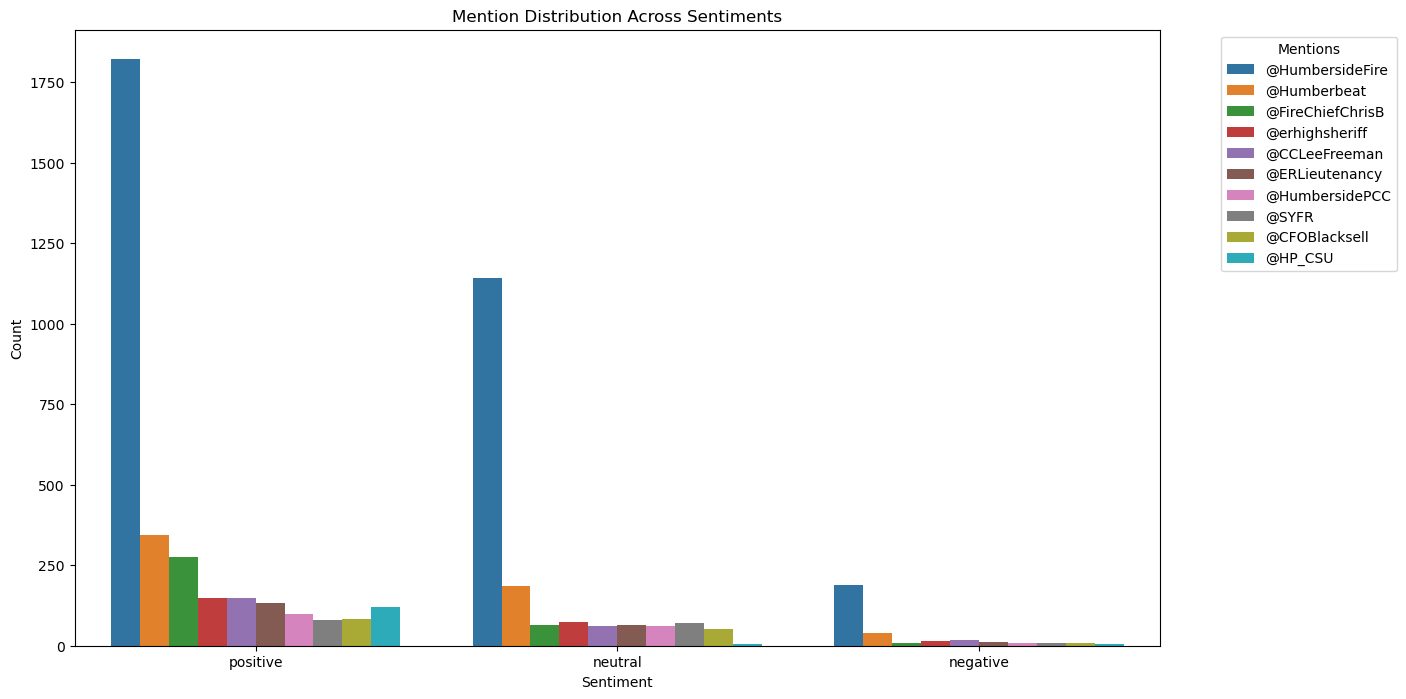

In [84]:
# Visualizing the frequency of mentions for each sentiment category
plt.figure(figsize=(14, 8))
sns.countplot(
    x='Sentiment',
    hue='Mentions',
    data=filtered_df.explode('Mentions'),
    order=filtered_df['Sentiment'].value_counts().index,
    hue_order=filtered_df['Mentions'].explode().value_counts().index[:top_mentions_limit]
)
plt.title('Mention Distribution Across Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend(title='Mentions', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [88]:
filtered_df

User          Username            UTC Date  \
0         Community Safety           @HP_CSU 2023-11-08 22:16:00   
1     JCPinHumber/NthYorks      @JCPinHumber 2023-11-08 14:01:00   
2         Community Safety           @HP_CSU 2023-11-08 13:35:18   
4         Kristian Gilmore  @GilmoreKri51696 2023-11-07 23:01:06   
5                     Beth        @Beth_Hanc 2023-11-07 20:18:02   
...                    ...               ...                 ...   
5517       Tony Clark QFSM  @blazerclark1237 2019-11-10 13:44:52   
5519     HFR Solutions CIC  @HFRSolutionsCIC 2019-11-10 09:45:06   
5520        Lyndsay Howden       @howden1987 2019-11-10 09:01:56   
5523         Lesley Tidder      @lallytidder 2019-11-09 21:46:38   
5525  UK USA FIRE & POLICE   @FIREUKANDWORLD 2019-11-09 08:48:44   

                                                  Tweet  Binders  \
0     Really informative talk from an Ex Member HM F...      NaN   
1     Procurement Assistant @HumbersideFire in Hull\...      NaN   
2     Better Together Event hosted by @Humberbeat co...      NaN   
4     @HallMohame77536 @Sinan05073661 @elquimeras @R...      NaN   
5     What an achievement for Our Rookie Mary, she h...      NaN   
...                                                 ...      ...   
5517  Fantastic turnout #RemembranceSunday at Howden...      NaN   
5519  On Remembrance Sunday, we are extremely proud ...      NaN   
5520  Proud to represent @HumbersideFire at the Clee...      NaN   
5523  @HumbersideFire I work at a homeless hostel, r...      NaN   
5525  1 confirmed #fatality so far from #England #fl...      NaN   

                                              Permalink  Retweets  \
0     https://www.twitter.com/user/status/1722377457...         0   
1     https://www.twitter.com/user/status/1722252885...         0   
2     https://www.twitter.com/user/status/1722246417...         2   
4     https://www.twitter.com/user/status/1722026420...         0   
5     https://www.twitter.com/user/status/1721985382...         0   
...                                                 ...       ...   
5517  https://www.twitter.com/user/status/1193524928...         2   
5519  https://www.twitter.com/user/status/1193464589...         1   
5520  https://www.twitter.com/user/status/1193453726...         3   
5523  https://www.twitter.com/user/status/1193283781...         0   
5525  https://www.twitter.com/user/status/1193088017...         0   

      Likes count  Impressions  Quotes  ...  \
0               6          185       0  ...   
1               1           58       0  ...   
2              14          440       0  ...   
4               0            8       0  ...   
5               1          415       0  ...   
...           ...          ...     ...  ...   
5517           15            0       0  ...   
5519           13            0       0  ...   
5520           11            0       0  ...   
5523            2            0       0  ...   
5525            0            0       0  ...   

                                               Mentions  \
0     [@Humberbeat, @NationalVPC, @ACC_TMc, @HP_Life...   
1                                     [@HumbersideFire]   
2     [@Humberbeat, @ACC_TMc, @HumbersidePCC, @Humbe...   
4     [@HallMohame77536, @Sinan05073661, @elquimeras...   
5                                                    []   
...                                                 ...   
5517                     [@HumbersideFire, @Humberbeat]   
5519                                  [@HumbersideFire]   
5520                                  [@HumbersideFire]   
5523                                  [@HumbersideFire]   
5525                                                 []   

                                          Cleaned_Tweet  \
0     really informative talk ex member hm force pro...   
1                        procurement assistant hull see   
2     better together event hosted community coming ...   
4                                    get launch p

# RoBERTa Emotions pretrained model

In [95]:
# Loading the Roberta model for emotion analysis
MODEL = 'cardiffnlp/twitter-roberta-base-emotion'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [96]:
# Function to perform Tokenization
def emotion_scores_roberta(example):
    if not isinstance(example, str):
        example = str(example)

    encoded_text = tokenizer([example], return_tensors='pt')
    output = model(**encoded_text)
    scores = output.logits[0].detach().numpy()
    scores = softmax(scores)
    return scores

In [97]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Cleaned_Tweet'] 
        myid = i  
        roberta_result = emotion_scores_roberta(text)
        res[myid] = roberta_result.tolist()
    except RuntimeError:
        print(f'Broke for id {myid}')


100%|██████████████████████████████████████████████████████████████████████████████| 5486/5486 [05:42<00:00, 16.01it/s]


In [98]:
# Converting the results to a DataFrame
results_df = pd.DataFrame(res).T
results_df.columns = ['Joy', 'Neutral', 'Anger', 'Sadness']  

# Adding the emotion scores to the existing DataFrame
df[['Joy', 'Neutral', 'Anger', 'Sadness']] = results_df[['Joy', 'Neutral', 'Anger', 'Sadness']]

# Mapping emotion labels 
df['Emotion'] = df[['Joy', 'Neutral', 'Anger', 'Sadness']].idxmax(axis=1)
df['Emotion'] = df['Emotion'].map({'Joy': 'joy', 'Neutral': 'neutral', 'Anger': 'anger', 'Sadness': 'sadness'})

print("Results DataFrame:")
print(df[['Cleaned_Tweet', 'Emotion']])

Results DataFrame:
                                                                                                                                                                                                                         Cleaned_Tweet  \
0                                                                                                                                                     really informative talk ex member hm force proud serve pcsogiven badge gratitude   
1                                                                                                                                                                                                       procurement assistant hull see   
2                                                                                                                            better together event hosted community coming engage u aspect effect themthank making difference together   
3                                            

C:\Users\Amro\AppData\Local\Temp\ipykernel_14300\2917858267.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Joy', 'Neutral', 'Anger', 'Sadness']] = results_df[['Joy', 'Neutral', 'Anger', 'Sadness']]
C:\Users\Amro\AppData\Local\Temp\ipykernel_14300\2917858267.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Joy', 'Neutral', 'Anger', 'Sadness']] = results_df[['Joy', 'Neutral', 'Anger', 'Sadness']]
C:\Users\Amro\AppData\Local\Temp\ipykernel_14300\2917858267.py:6: SettingWithCopyWarning: 
A val

In [99]:
df['Emotion'].value_counts()

Emotion
neutral    2969
sadness    1142
anger       794
joy         581
Name: count, dtype: int64

In [100]:
# List of user accounts to exclude
exclude_users = ['Humberside Fire & Rescue', 'Chris Blacksell DL','Phil Shillito', 'National Highways: Yorkshire', 'Lincolnshire Fire and Rescue']

In [101]:
# Filtering out rows with specified user accounts
filtered_df = df[~df['User'].isin(exclude_users)]

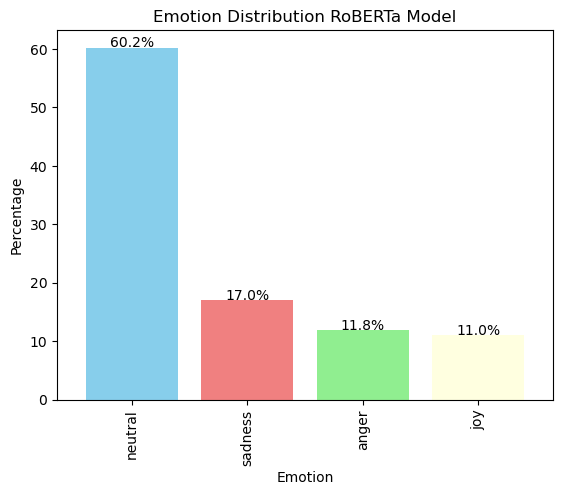

In [107]:
sentiment_counts = filtered_df['Emotion'].value_counts()

# Calculating percentages
total_samples = len(filtered_df)
sentiment_percentages = (sentiment_counts / total_samples) * 100

sentiment_percentages.plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen','lightyellow'], width=0.8)

# Adding labels and title
plt.xlabel('Emotion')
plt.ylabel('Percentage')
plt.title('Emotion Distribution RoBERTa Model')

for i, percentage in enumerate(sentiment_percentages):
    plt.text(i, percentage + 0.1, f'{percentage:.1f}%', ha='center')

# Save the figure and show the plot
plt.savefig('Emotion Distribution For Emotions Classification.png')
plt.show()

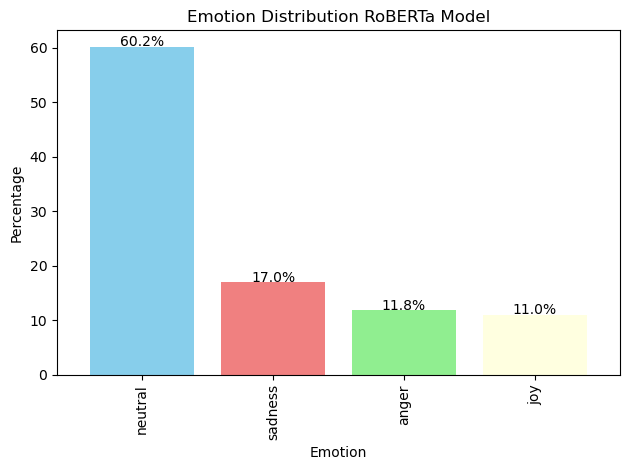

In [108]:

sentiment_counts = filtered_df['Emotion'].value_counts()

# Calculating percentages
total_samples = len(filtered_df)
sentiment_percentages = (sentiment_counts / total_samples) * 100

# Bar chart
sentiment_percentages.plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen', 'lightyellow'], width=0.8)

# Adding labels and title
plt.xlabel('Emotion')
plt.ylabel('Percentage')
plt.title('Emotion Distribution RoBERTa Model')

for i, percentage in enumerate(sentiment_percentages):
    plt.text(i, percentage + 0.1, f'{percentage:.1f}%', ha='center')

plt.tight_layout()


plt.savefig('Emotion Distribution For Emotions Classification.png')
plt.show()

In [105]:
emotions_to_display = ['neutral', 'anger', 'joy', 'sadness']


sampled_rows = {}

# Iterating through each emotion 
for emotion in emotions_to_display:
    sampled_rows[emotion] = filtered_df[filtered_df['Emotion'] == emotion].sample(50)


result_df = pd.concat(sampled_rows.values())


In [106]:
result_df

User          Username  \
248                                                   JB        @JBPara999   
5497                                       Katy Garrigan         @katgaz79   
3426                                            Class EH      @ClassEH_NWA   
3379                                      Laura Williams  @Laura_1Williams   
840                                                Mrs D    @MrsDonteaches   
414             Greater Manchester Fire & Rescue Service   @manchesterfire   
3792                              Wheeler Primary School       @Wheeler_PS   
845                                                James      @jimbolimbo9   
3777                                        Paul Grimley       @Ongo_PaulG   
547                            The Fire Fighters Charity  @firefighters999   
4737                                         Lou Soppitt      @Louby_Lou14   
2870                                    HullPublicHealth       @HealthHull   
2912                                       Fire Engineer   @FireEngineer81   
1939                    National Volunteer Police Cadets      @NationalVPC   
2583                                           Ash Class     @Ash_YAcademy   
5226                                JCPinHumber/NthYorks      @JCPinHumber   
3025                    Cheshire Fire and Rescue Service     @CheshireFire   
2105                                        Garry Mackay         @GarryMac   
184                                           Mark Walsh       @HullWalshy   
2767                    Weelsby Academy Reception Class.       @FS2Weelsby   
563                                             CHCP CIC         @CHCPHull   
5489                                    Community Safety           @HP_CSU   
1826                                        Peter Arnold  @RSSS_PeteArnold   
3833                                         David Scott   @Davidpaulscott   
1445                            High Sheriff East Riding    @erhighsheriff   
726                                    Ready Steady Read   @readysteadread   
5074                                    Healthwatch Hull  @HealthwatchHull   
1790                                    Community Safety           @HP_CSU   
885                                      Dave stephenson         @stivvvvy   
991                                   Safer Roads Humber      @HumberRoads   
2795                                     simon donnachie   @simondonnachie   
3605                                        Paul McCourt   @Paul_F_McCourt   
2006                               Andrew Horncastle MBE     @ANHorncastle   
3218                                Hedon Primary School  @HedonPrimarySch   
3913              West Yorkshire Fire and Rescue Service            @WYFRS   
3054                                  The Ashcourt Group    @AshcourtGroup   
2623                                               Col_H    @CheshireArson   
5460                                        Hazel Bullen      @BullenHazel   
4779                                              darren           @MRT2k9   
1646         Humberside Police - North East Lincolnshire    @HumberbeatNEL   
1269                                  St Peter & St Paul  @Lakeside_school   
3136                                          John Askew         @108jonny   
45                                            Mark Walsh       @HullWalshy   
3161                                Humber Energy Skills  @HumEnergySkills   
3823                                          John Byrne      @CMOSWLondon   
509                                   Vicky Shakesby MBE    @VickyShakesby   
1559                                      Jake Zuckerman    @jakezuckerman   
2238                                         Ellie Hardy         @21_hardy   
3238                                      Lode Ergometry   @Lode_Ergometry   
1033                                         David Scott   @Davidpaulscott   
5037                                          YOURhealth    @NHSYOURhealth

# XLNET Model predictions for sentiment analysis

In [110]:
# Loading the saved tokenizer
tokenizer = XLNetTokenizer.from_pretrained('XLNET_sentiment_tokenizer')

# Load the saved model
model = XLNetForSequenceClassification.from_pretrained('XLNET_sentiment_model')

In [111]:
# Tokenization the 'Cleaned_Tweet' column
tokenized_texts = filtered_df['Cleaned_Tweet'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=128))

In [112]:
# adding Padding sequences to a consistent length
max_len = max(len(seq) for seq in tokenized_texts)
padded_sequences = torch.tensor([seq + [tokenizer.pad_token_id] * (max_len - len(seq)) for seq in tokenized_texts])

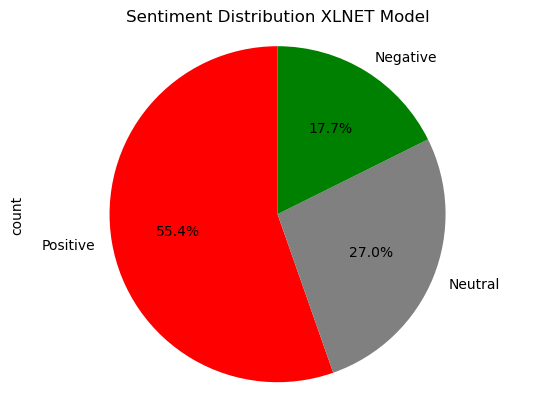

In [89]:
sentiment_counts = filtered_df['XLNET_prediction'].value_counts()
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['red', 'gray', 'green'])
plt.title('Sentiment Distribution XLNET Model')
plt.axis('equal') 

plt.savefig('Sentiment Distribution for XLNET.png', bbox_inches='tight')
plt.show()